# Sear for Bad spectra and Bad tracking effect

- look for which parameter allow to identify a bad spectrum

 work with Weakly_2023_11
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/03/05
- last update : 2023/04/07

- Spectractor https://github.com/lsst/Spectractor/
- Spectractor Version 2.4
- branch lsst-dev
- available in version w_2023_11 by default


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_11/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/eups 	setup


In [2]:
! eups list -s lsst_distrib

   gdf42428520+c82c1836b5 	current w_2023_11 setup


In [3]:
import h5py

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
import pickle

In [7]:
from astropy.time import Time
import astropy.units as u

## Config

In [8]:
FLAG_MOUNT_ERRORS= True

### Butler

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
#repo = "/sdf/group/rubin/repo/oga/"
repo = "/repo/embargo/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser & collection

- make your choice

In [10]:
DateToRuncollection = {

 # september 2022
 20220912 :  "u/dagoret/BPS_manyspectro_v60", # Missing collection
 20220913 :  "u/dagoret/BPS_manyspectro_v61", # Missing collection
 20220914 :  "u/dagoret/BPS_manyspectro_v62", # Missing collection  
    
 20220927 :  "u/dagoret/BPS_manyspectro_v63", # Mount errors available, mitigé
 20220928 :  "u/dagoret/BPS_manyspectro_v64", # Mount errors available, very nice spectra
 20220929 :  "u/dagoret/BPS_manyspectro_v65", # Mount errors available, very nice spectra
    
    
 # october 2022
 20221012 :  "u/dagoret/BPS_manyspectro_v56", # mount errors , nice, all good
 20221025 :  "u/dagoret/BPS_manyspectro_v57", # mount errors, very very bad spectra, must remove run
 20221026 :  "u/dagoret/BPS_manyspectro_v58", # mount errors,  nice spectra, all good
 20221027 :  "u/dagoret/BPS_manyspectro_v59", # mount errors,  nice spectra, all good
    
 # november 2022
 20221109 :  "u/dagoret/BPS_manyspectro_v53", # mount errors, nice spectra, few bad labelled as good 
 20221110 :  "u/dagoret/BPS_manyspectro_v54", # mount errors available, many bad rec spectra, few bad labelled as good, versy strange
 20221123 :  "u/dagoret/BPS_manyspectro_v55", # mount errors , nice   
    
 # december 2022   
 20221207 :  "u/dagoret/BPS_manyspectro_v48", # No mount error, nice spectra
 20221208 :  "u/dagoret/BPS_manyspectro_v49", # No mount error, nice spectra, one bad labelled as good
 20221209 :  "u/dagoret/BPS_manyspectro_v50", # No mount error, spectra at distance from optical center, very interesting
 20221210 :  "u/dagoret/BPS_manyspectro_v51", # No mount error, bof
 20221212 :  "u/dagoret/BPS_manyspectro_v52", # No mount error, very bad gains and instability    
    
 #January 2023 
 20230117 :  "u/dagoret/BPS_manyspectro_v79", # no mount errors, some mucol spectra that looks good are rejected on DCCD
 20230118 :  "u/dagoret/BPS_manyspectro_v80", # no mount error, some mucol looking good are rejected, many bad centroid calculation
 20230119 :  "u/dagoret/BPS_manyspectro_v77", # no mount errors, many blurred spectra probably due to strong tracking error
 20230131 :  "u/dagoret/BPS_manyspectro_v78", # missing for moment

 #february 2023
 20230214 :  "u/dagoret/BPS_manyspectro_v42", # no mount errors, nothing special
 20230215 :  "u/dagoret/BPS_manyspectro_v43", # mount errors, OK
 20230216 :  "u/dagoret/BPS_manyspectro_v44", # mount errors, OK, nice spectra 
 20230228 :  "u/dagoret/BPS_manyspectro_v70", # No mount error,OK nice spectra
    
 #march 2023  
 20230301 :  "u/dagoret/BPS_manyspectro_v71", # no mount errors, OK many spectra
 20230302 :  "u/dagoret/BPS_manyspectro_v72", # no mount error, sometime bas subtraction of order2 on HD38666 (mucol) 
 20230315 :  "u/dagoret/BPS_manyspectro_v73", # mount errors
 20230316 :  "u/dagoret/BPS_manyspectro_v74", # mount errors   
    
}

In [11]:
DATE = 20221025
my_collection = DateToRuncollection[DATE]

filterdispersername = "empty~holo4_003"

RUNSELECTION = 20230330
#RUNSELECTION = 20230403

# List of Dataset types avalaible in my collection

## List of dataset types

In [12]:
list(registry.queryDatasetTypes("*spec*"))

[DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict),
 DatasetType('spectraction', {band, instrument, detector, physical_filter, visit}, Spectraction),
 DatasetType('spectractorImage', {band, instrument, detector, physical_filter, visit}, SpectractorImage),
 DatasetType('spectractorSpectrum', {band, instrument, detector, physical_filter, visit}, SpectractorSpectrum)]

## list of datasets

In [13]:
list(registry.queryDatasets("*spec*", collections=[my_collection]))[:30]

[DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022102500207, ...}, id=45067d2d-e727-4397-b78b-397247703b5a, run='u/dagoret/BPS_manyspectro_v57/20230313T155733Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022102500172, ...}, id=20ce1fba-47c4-40d1-867e-dc6f92b6a99f, run='u/dagoret/BPS_manyspectro_v57/20230313T155733Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022102500217, ...}, id=5a416155-cdb0-4c34-b071-f7f4c326fac6, run='u/dagoret/BPS_manyspectro_v57/20230313T155733Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2

### Spectractor

In [14]:
configmode = "PSF2DFFM_REBIN2"
#configmode = "PSF2DFFM_REBIN1"
#ext="_b"
specver="specV2.4"

https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

In [15]:
output_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.hdf5"
input_summary_file = f"fullsummaryspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.csv"

### The collection

In [16]:
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [17]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Read Mout Error summary file

In [18]:
if FLAG_MOUNT_ERRORS:
    df_mounterrors = pd.read_csv("mountErrors.csv")
    df=df_mounterrors[df_mounterrors["date_obs"] == DATE ]
    if len(df) == 0:
        FLAG_MOUNT_ERRORS = False
        

In [19]:
df_mounterrors

Unnamed: 0    idx  date_obs  seq       exposure  status    az_rms  \
0             437    437  20220908   66  2022090800066    True  0.040777   
1             444    444  20220908   73  2022090800073    True  0.011192   
2             447    447  20220912    3  2022091200003    True  0.006601   
3             516    516  20220912   72  2022091200072    True  0.004987   
4             522    522  20220912   78  2022091200078    True  0.098272   
...           ...    ...       ...  ...            ...     ...       ...   
16645       43253  43253  20230321   43  2023032100043    True  0.010867   
16646       43254  43254  20230321   44  2023032100044    True  0.010794   
16647       43255  43255  20230321   45  2023032100045    True  0.023044   
16648       43256  43256  20230321   46  2023032100046    True  0.265174   
16649       43262  43262  20230321   52  2023032100052    True  0.214062   

         el_rms   rot_rms  image_az_rms  image_el_rms  image_rot_rms  
0      0.026023  0.291703      0.020020      0.026023       0.000396  
1      0.007489  0.614963      0.005322      0.007489       0.000835  
2      0.005453  0.706174      0.005130      0.005453       0.000959  
3      0.004895  0.159655      0.003876      0.004895       0.000217  
4      0.052172  0.148901      0.048586      0.052172       0.000202  
...         ...       ...           ...           ...            ...  
16645  0.011750  0.004012      0.009384      0.011750       0.000005  
16646  0.007538  0.007706      0.009318      0.007538       0.000010  
16647  0.014788  0.300176      0.019884      0.014788       0.000407  
16648  0.060447  0.004043      0.246965      0.060447       0.000005  
16649  0.049427  0.007835      0.198238      0.049427       0.000011  

[16650 rows x 12 columns]

In [20]:
df

Unnamed: 0    idx  date_obs  seq       exposure  status    az_rms  \
6695       17385  17385  20221025    4  2022102500004    True  0.053247   
6696       17386  17386  20221025    5  2022102500005    True  0.024536   
6697       17465  17465  20221025   84  2022102500084    True  0.100011   
6698       17466  17466  20221025   85  2022102500085    True  0.167648   
6699       17467  17467  20221025   86  2022102500086    True  0.109948   
...          ...    ...       ...  ...            ...     ...       ...   
7467       18237  18237  20221025  856  2022102500856    True  0.119290   
7468       18238  18238  20221025  857  2022102500857    True  0.101276   
7469       18239  18239  20221025  858  2022102500858    True  0.088169   
7470       18240  18240  20221025  859  2022102500859    True  0.133586   
7471       18241  18241  20221025  860  2022102500860    True  0.082285   

        el_rms   rot_rms  image_az_rms  image_el_rms  image_rot_rms  
6695  0.009466  1.506726      0.018143      0.009466       0.002045  
6696  0.007151  2.157254      0.010293      0.007151       0.002928  
6697  0.065183  0.356034      0.049793      0.065183       0.000483  
6698  0.012923  0.155233      0.083468      0.012923       0.000211  
6699  0.039829  0.169859      0.054737      0.039829       0.000231  
...        ...       ...           ...           ...            ...  
7467  0.170738  0.193704      0.046370      0.170738       0.000263  
7468  0.130028  0.191046      0.039477      0.130028       0.000259  
7469  0.067649  0.213523      0.034441      0.067649       0.000290  
7470  0.142172  0.214348      0.052331      0.142172       0.000291  
7471  0.079666  0.232476      0.032302      0.079666       0.000316  

[777 rows x 12 columns]

In [21]:
#FLAG_MOUNT_ERRORS = False 

## Read full summary files

In [22]:
df_summary=pd.read_csv(input_summary_file,index_col=0)

In [23]:
df_summary

index       exposure                   spec_date_obs spec_target_label  \
0       0  2022102500161  2022-10-26T01:15:45.194003332Z          HD185975   
1       1  2022102500162  2022-10-26T01:16:18.158992888Z          HD185975   
2       2  2022102500166  2022-10-26T01:18:34.461504140Z           HD14943   
3       3  2022102500167  2022-10-26T01:19:07.368503091Z           HD14943   
4       4  2022102500171  2022-10-26T01:21:07.415995665Z            HD2811   
5       5  2022102500172  2022-10-26T01:21:40.238493572Z            HD2811   
6       6  2022102500176  2022-10-26T01:26:13.599503467Z          HD009051   
7       7  2022102500177  2022-10-26T01:26:46.598497351Z          HD009051   
8       8  2022102500181  2022-10-26T01:29:00.244504649Z           HD14943   
9       9  2022102500182  2022-10-26T01:29:33.163500968Z           HD14943   
10     10  2022102500186  2022-10-26T01:31:32.106500756Z            HD2811   
11     11  2022102500187  2022-10-26T01:32:04.921992834Z            HD2811   
12     12  2022102500191  2022-10-26T01:34:18.771491130Z          HD009051   
13     13  2022102500192  2022-10-26T01:34:51.765999303Z          HD009051   
14     14  2022102500196  2022-10-26T01:37:05.897000450Z           HD14943   
15     15  2022102500197  2022-10-26T01:37:38.804007860Z           HD14943   
16     16  2022102500201  2022-10-26T01:39:38.662992800Z            HD2811   
17     17  2022102500202  2022-10-26T01:40:11.570002842Z            HD2811   
18     18  2022102500206  2022-10-26T01:42:12.137996225Z           HD14943   
19     19  2022102500207  2022-10-26T01:42:44.949502874Z           HD14943   
20     20  2022102500211  2022-10-26T01:44:59.411994280Z          HD009051   
21     21  2022102500212  2022-10-26T01:45:32.304503756Z          HD009051   
22     22  2022102500216  2022-10-26T01:47:49.071499266Z            HD2811   
23     23  2022102500217  2022-10-26T01:48:21.981504045Z            HD2811   
24     24  2022102500221  2022-10-26T01:50:21.850509384Z           HD14943   
25     25  2022102500222  2022-10-26T01:50:54.663504376Z           HD14943   
26     26  2022102500226  2022-10-26T01:53:11.691493146Z          HD009051   
27     27  2022102500227  2022-10-26T01:53:44.685001035Z          HD009051   

   spec_filter_label  spec_airmass  spec_pressure  spec_temperature  \
0              empty      1.858105              0                 0   
1              empty      1.858499              0                 0   
2              empty      1.385008              0                 0   
3              empty      1.383123              0                 0   
4              empty      1.088635              0                 0   
5              empty      1.087945              0                 0   
6              empty      1.199132              0                 0   
7              empty      1.197551              0                 0   
8              empty      1.348940              0                 0   
9              empty      1.347228              0                 0   
10             empty      1.075656              0                 0   
11             empty      1.075053              0                 0   
12             empty      1.175938              0                 0   
13             empty      1.174498              0                 0   
14             empty      1.323078              0                 0   
15             empty      1.321481              0                 0   
16             empty      1.066712              0                 0   
17             empty      1.066169              0                 0   
18             empty      1.307665              0                 0   
19             empty      1.306136              0                 0   
20             empty      1.148287              0                 0   
21             empty      1.146996              0                 0   
22             empty      1.058678              0                 0   
23             empty      1.058199   

In [24]:
if FLAG_MOUNT_ERRORS:
    list_of_columns = df_summary.columns
    me_names = ['me_az_rms', 'me_el_rms', 'me_rot_rms','me_image_az_rms', 'me_image_el_rms', 'me_image_rot_rms']
    #print(list_of_columns)
    
    for me_name in me_names:
        print(f"{me_name} found in DataFrame" )
    else:
        print(f"{me_name} NOT found in DataFrame" )
        

me_az_rms found in DataFrame
me_el_rms found in DataFrame
me_rot_rms found in DataFrame
me_image_az_rms found in DataFrame
me_image_el_rms found in DataFrame
me_image_rot_rms found in DataFrame
me_image_rot_rms NOT found in DataFrame


In [25]:
#FLAG_MOUNT_ERRORS = True

## Loop on exposures

In [26]:
#outfile.close()

In [27]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers


for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    
    #through old runs
    date_of_run = int(ref.run.split("/")[-1].split("T")[0])
    if date_of_run< RUNSELECTION :
        continue
 
    
    
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    the_exposure_key = str(the_exposure)
    
    
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectractorSpectrum', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022102500211}
visit...................: 2022102500211
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v57/20230313T155733Z
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022102500227}
visit...................: 2022102500227
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v57/20230313T155733Z
============= (2) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrume

In [28]:
index = 0

spec = all_spec[index]

In [29]:
def DumpSpectrum(spec):
    print("--------------------------------------------")
    print("spec.target.label\t",spec.target.label)
    print("spec.filter_label\t",spec.filter_label)
    print("spec.airmass\t",spec.airmass)
    print("spec.date_obs\t",spec.date_obs)
    print("spec.temperature\t",spec.temperature)
    print("spec.pressure\t",spec.pressure)
    print("spec.humidity\t",spec.humidity)    
    #print("spec.ra\t",spec.ra)
    print("spec.dec\t",spec.dec)
    print("spec.hour_angle\t",spec.hour_angle)
    print("spec.parallactic_angle\t",spec.parallactic_angle)
    print("spec.camera_angle\t", spec.camera_angle)
    print("--------------------------------------------")
    print("spec.order\t",spec.order)
    print("spec.lambdas\t",spec.lambdas)
    print("spec.data\t",spec.data)
    print("spec.err\t",spec.err)
    print("spec.covmatrix\t",spec.cov_matrix)
    print("--------------------------------------------")
    print("spec.data_next_order\t",spec.data_next_order)
    print("spec.err_next_order\t",spec.err_next_order)

In [30]:
DumpSpectrum(spec)

--------------------------------------------
spec.target.label	 HD2811
spec.filter_label	 empty
spec.airmass	 1.06671173103107
spec.date_obs	 2022-10-26T01:39:38.662992800Z
spec.temperature	 0
spec.pressure	 0
spec.humidity	 0
spec.dec	 -43.5782259986965
spec.hour_angle	 -19.57689265876609
spec.parallactic_angle	 -55.87092373930656
spec.camera_angle	 235.955332695642
--------------------------------------------
spec.order	 1
spec.lambdas	 [ 302.2340931   302.95696975  303.67983549 ... 1109.22340756 1109.91876569
 1110.61408676]
spec.data	 [-7.03265720e-13 -1.27421524e-17 -1.34823810e-17 ...  2.81536361e-10
 -5.72946146e-10  2.32155702e-10]
spec.err	 [2.74571608e-14 8.17609400e-18 7.36179293e-18 ... 3.81042665e-10
 2.72682711e-10 7.67050905e-11]
spec.covmatrix	 [[ 7.53895681e-28  9.08265252e-34 -7.28775482e-34 ... -2.34132691e-28
   8.34020862e-28 -3.27538408e-28]
 [ 9.08265323e-34  6.68485131e-35  6.72668711e-37 ...  4.94976281e-32
  -8.31546317e-32  3.19810617e-32]
 [-7.28775597e-34  

## Plot

In [31]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 188
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

In [32]:
all_histnames = ['spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift']
all_histminval = [chi2_fit_min, d2ccd_min, pixshift_min ]
all_histmaxval = [chi2_fit_max, d2ccd_max, pixshift_max ]

In [33]:
all_histnames2 = ["me_az_rms","me_el_rms","me_rot_rms","me_image_az_rms","me_image_el_rms","me_image_rot_rms"]

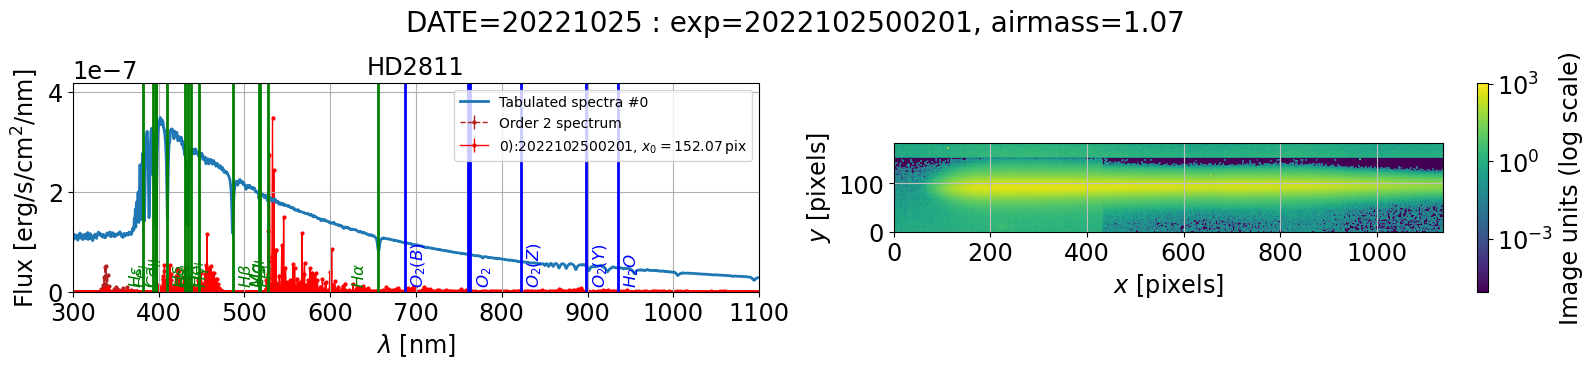

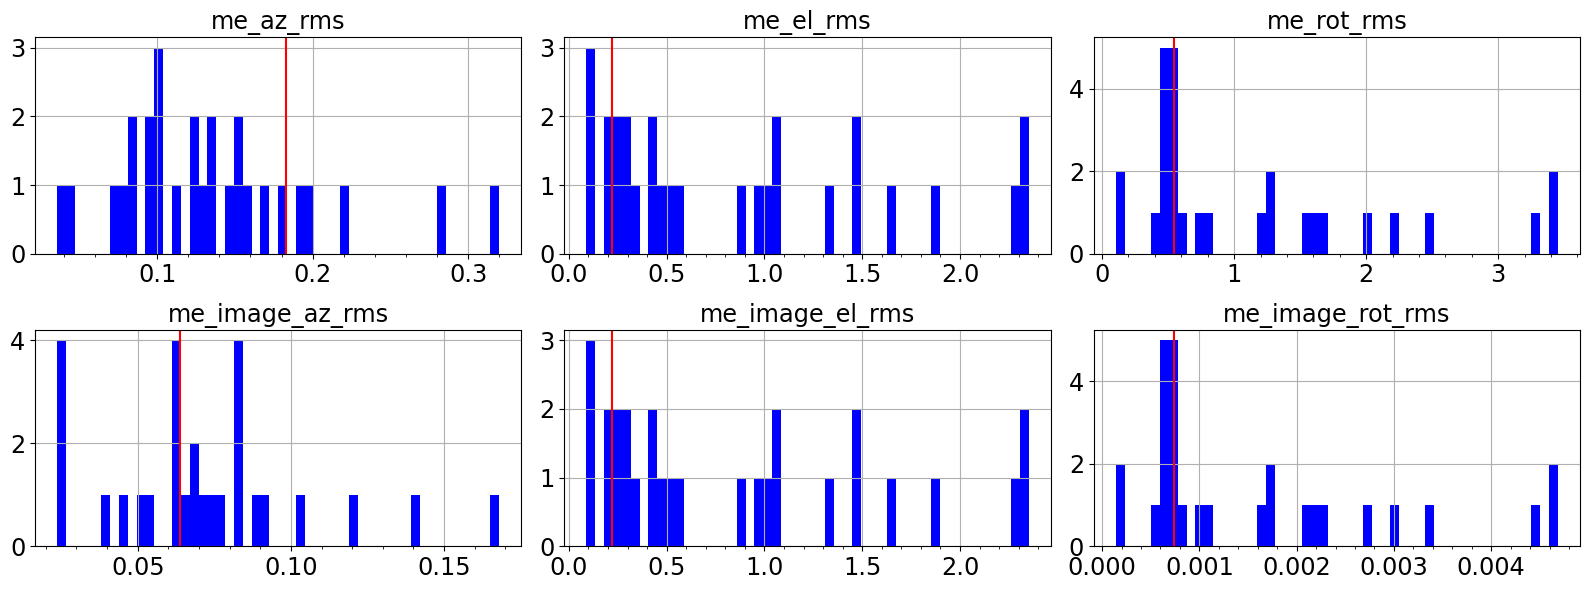

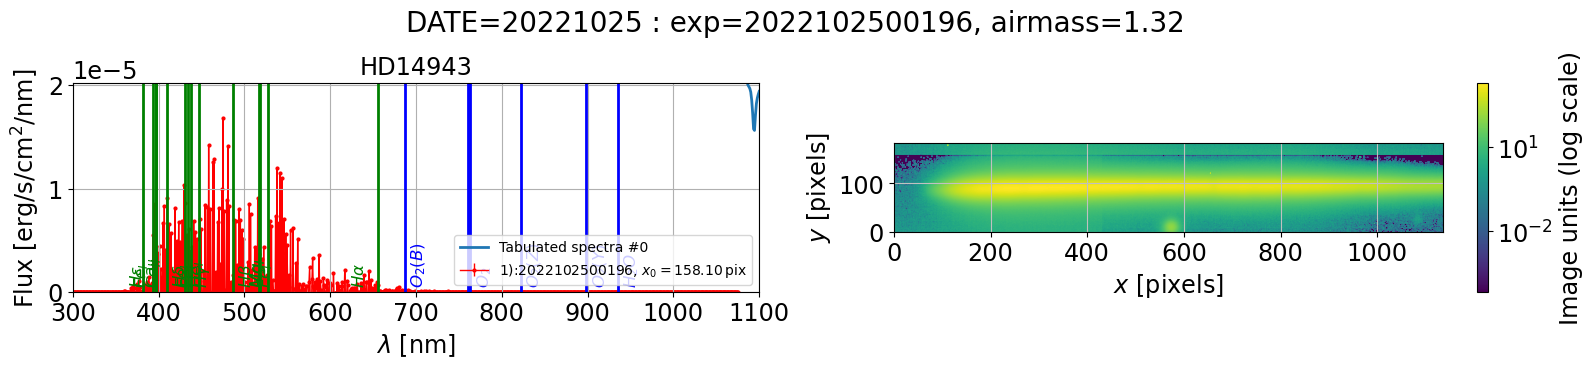

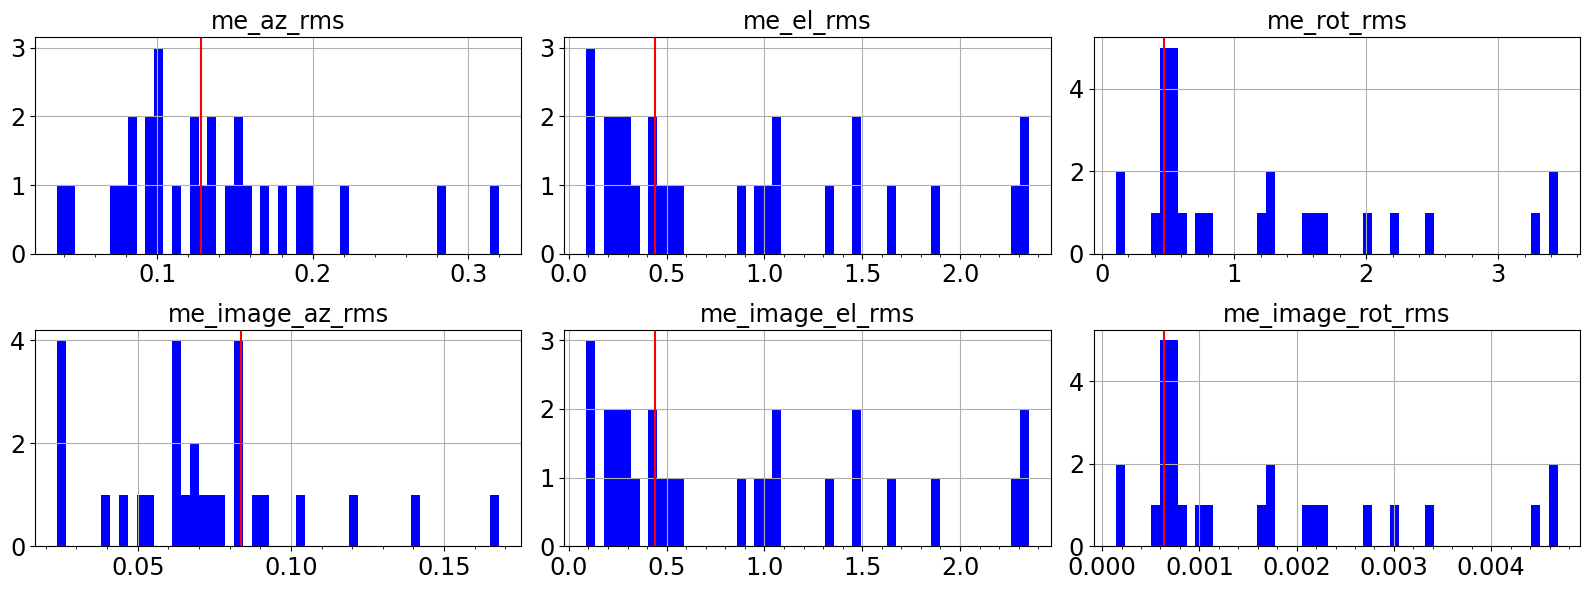

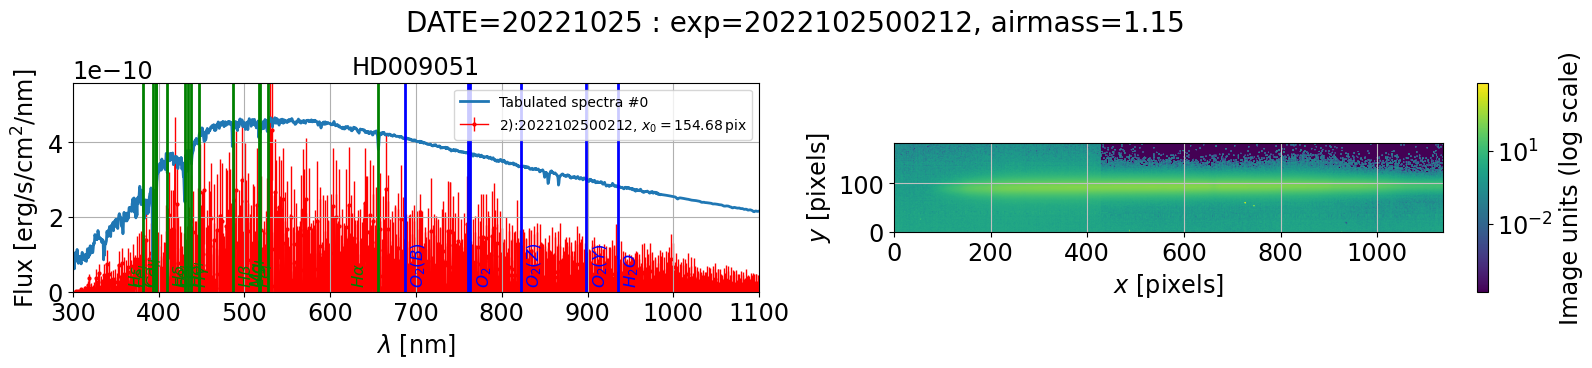

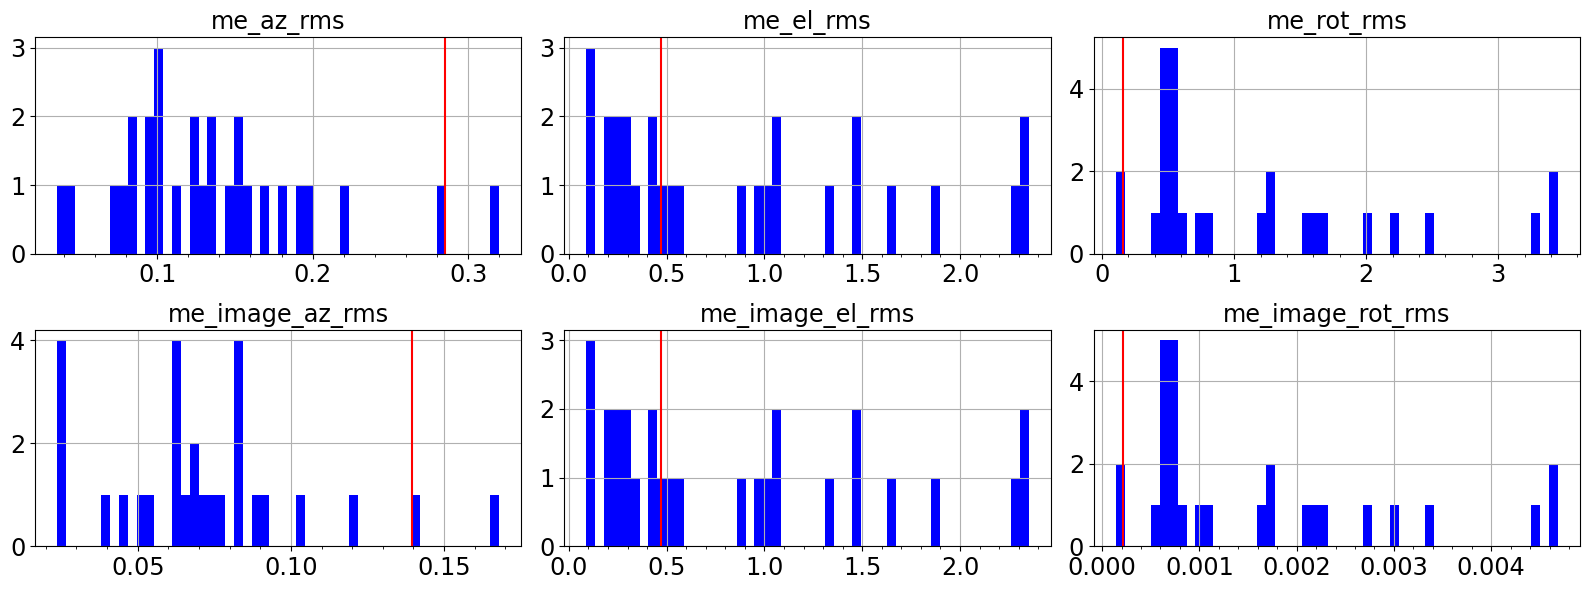

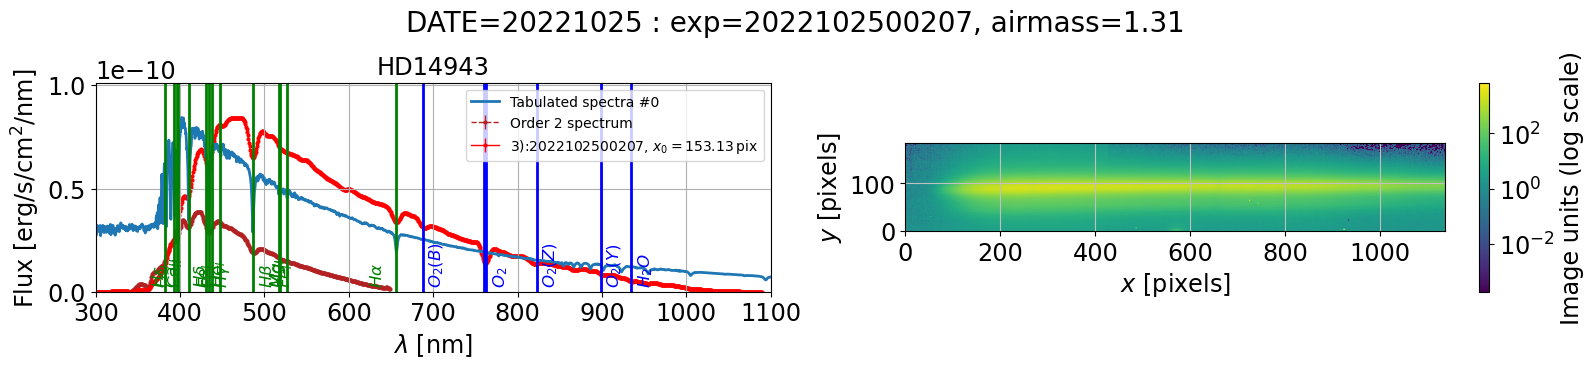

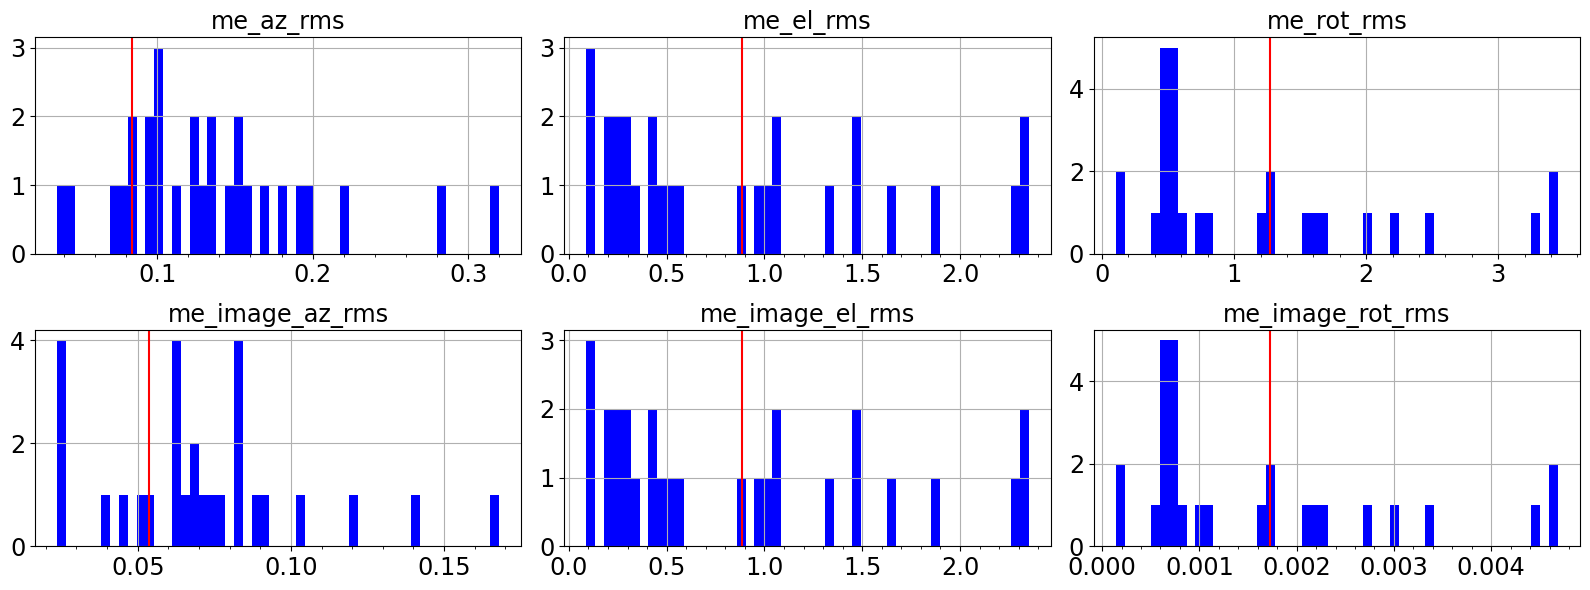

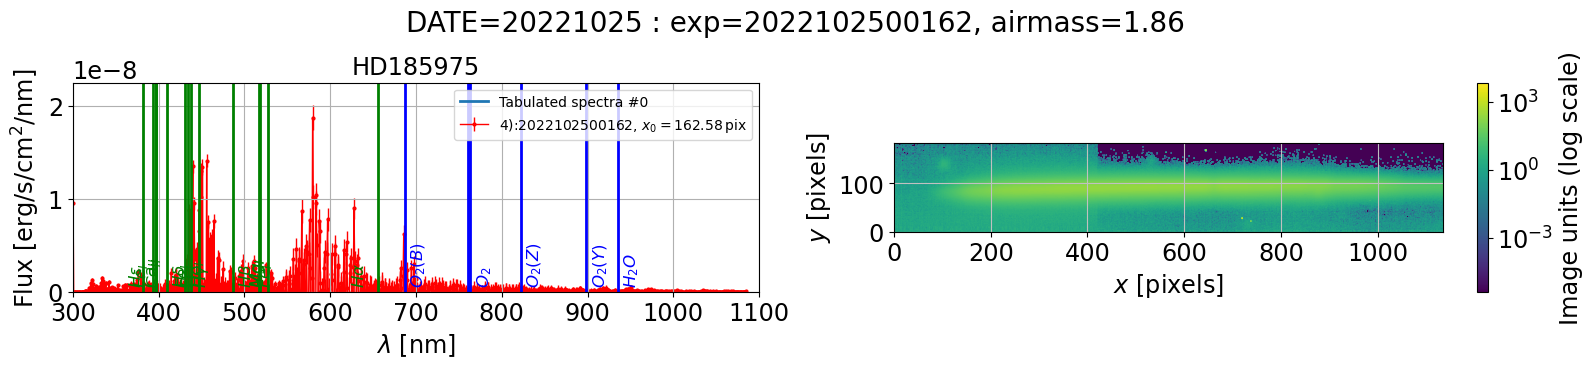

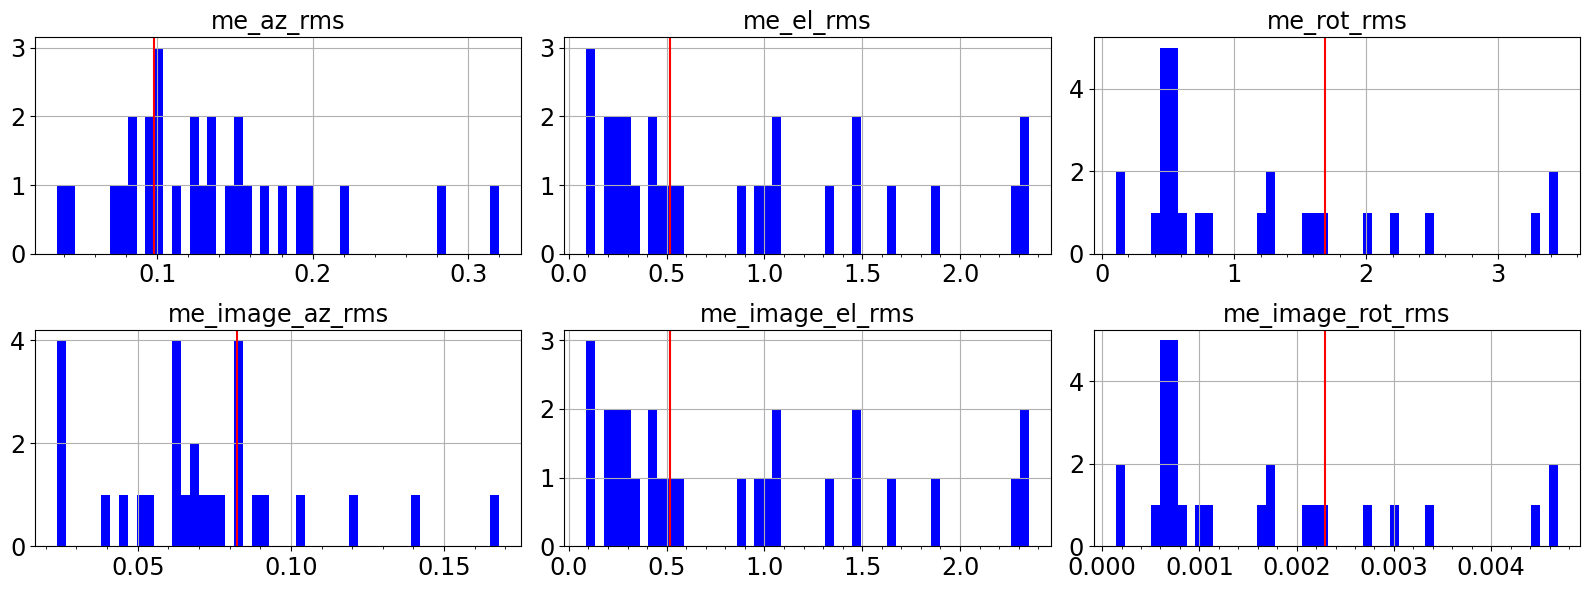

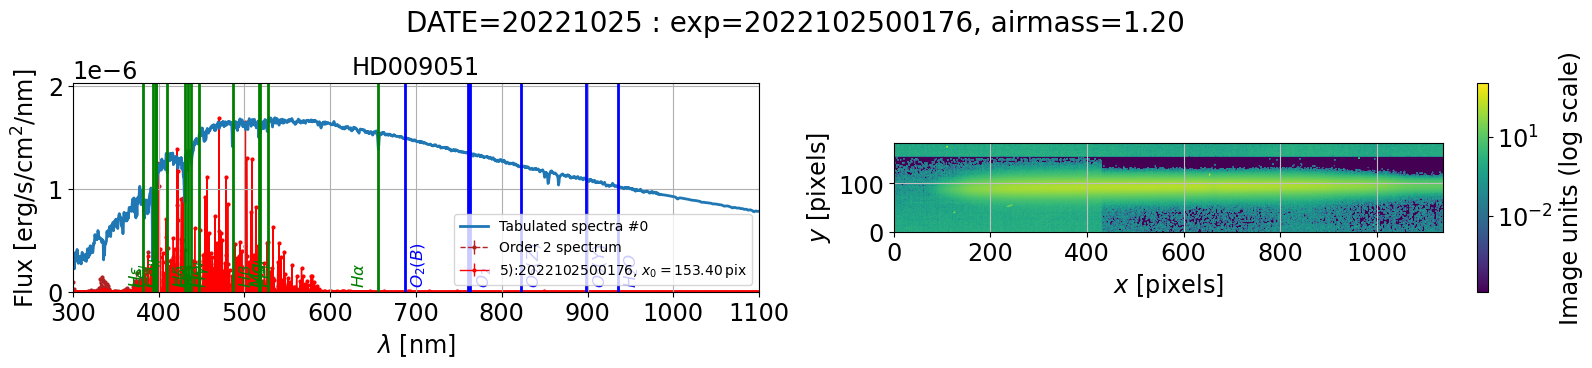

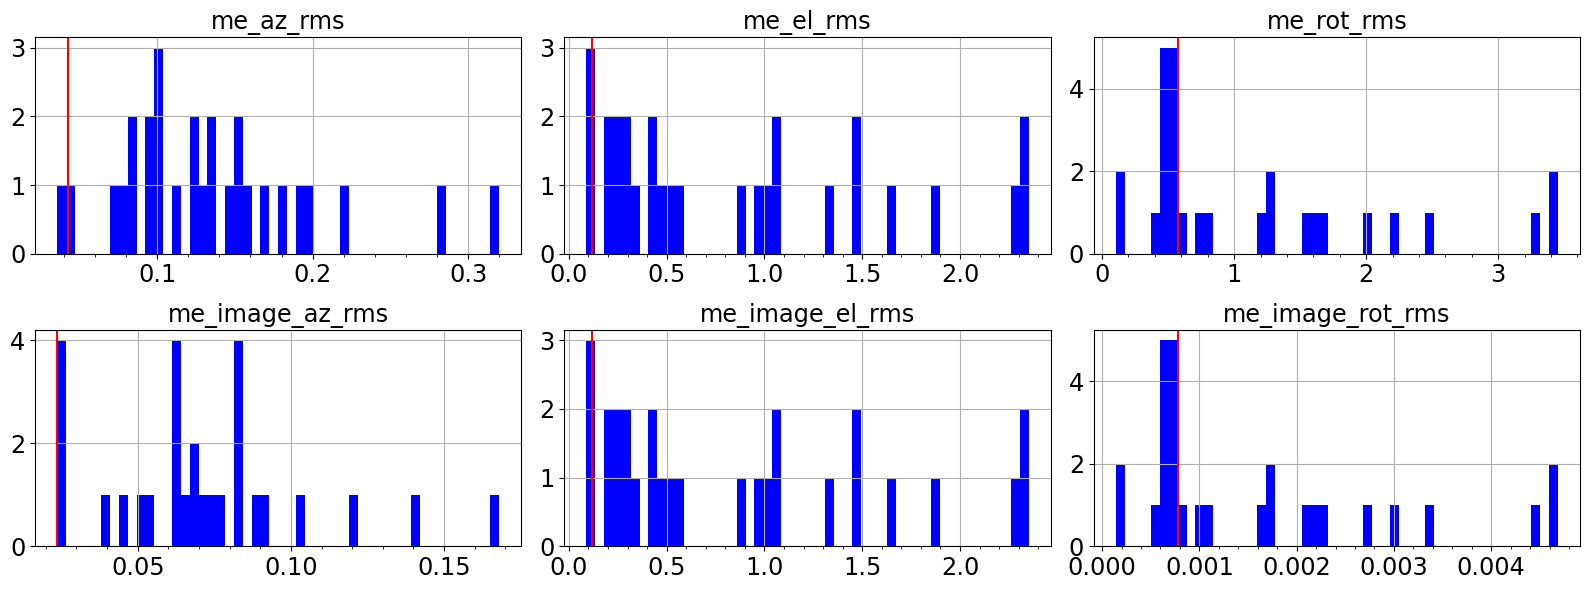

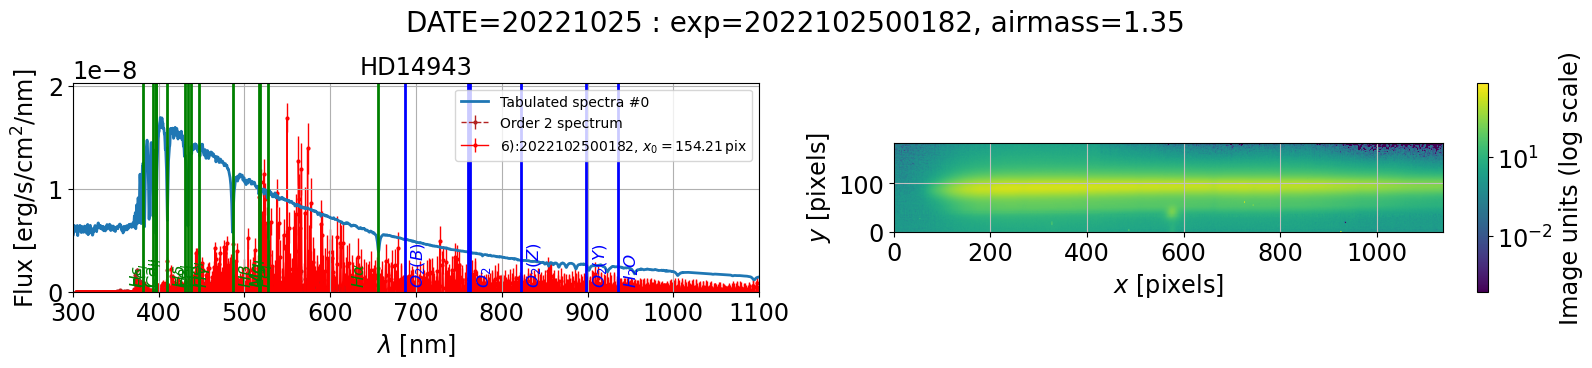

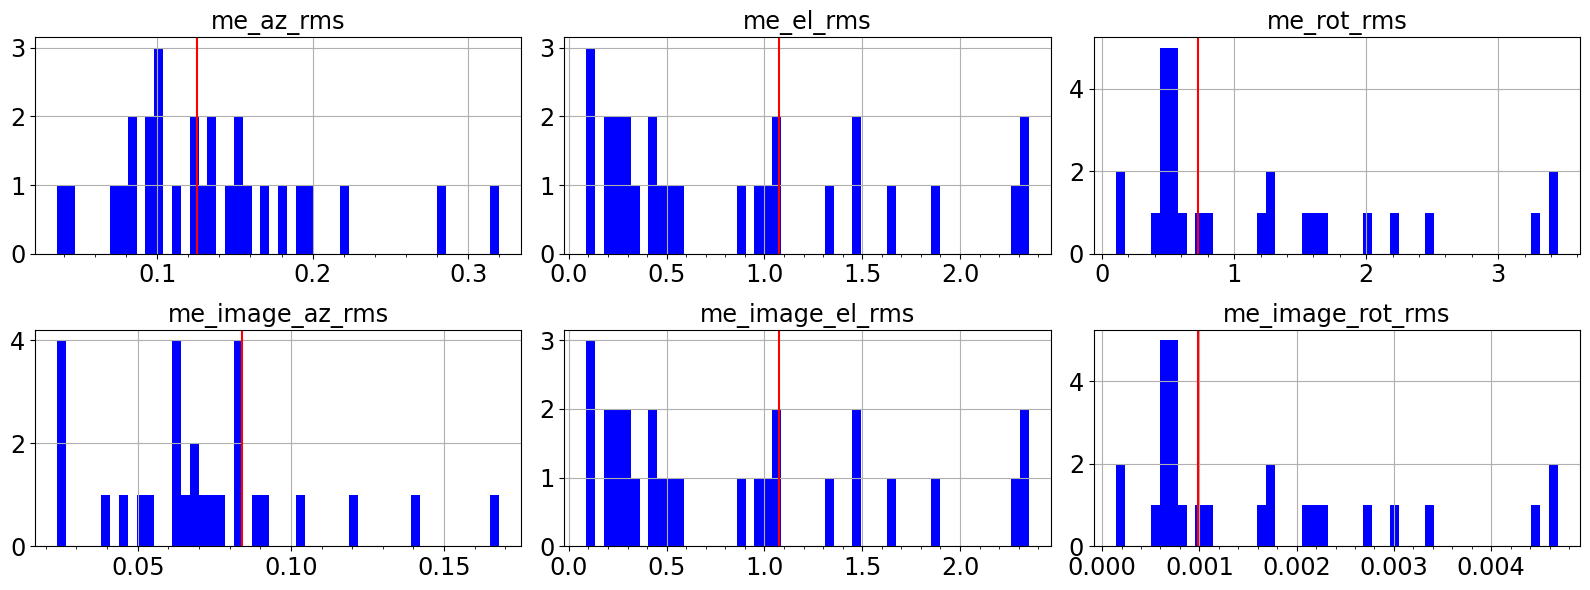

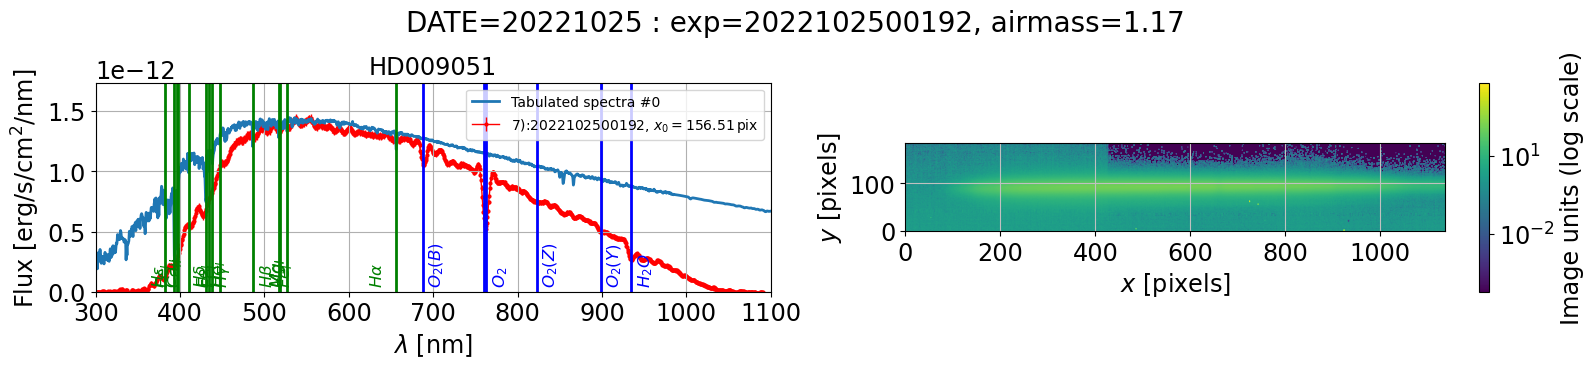

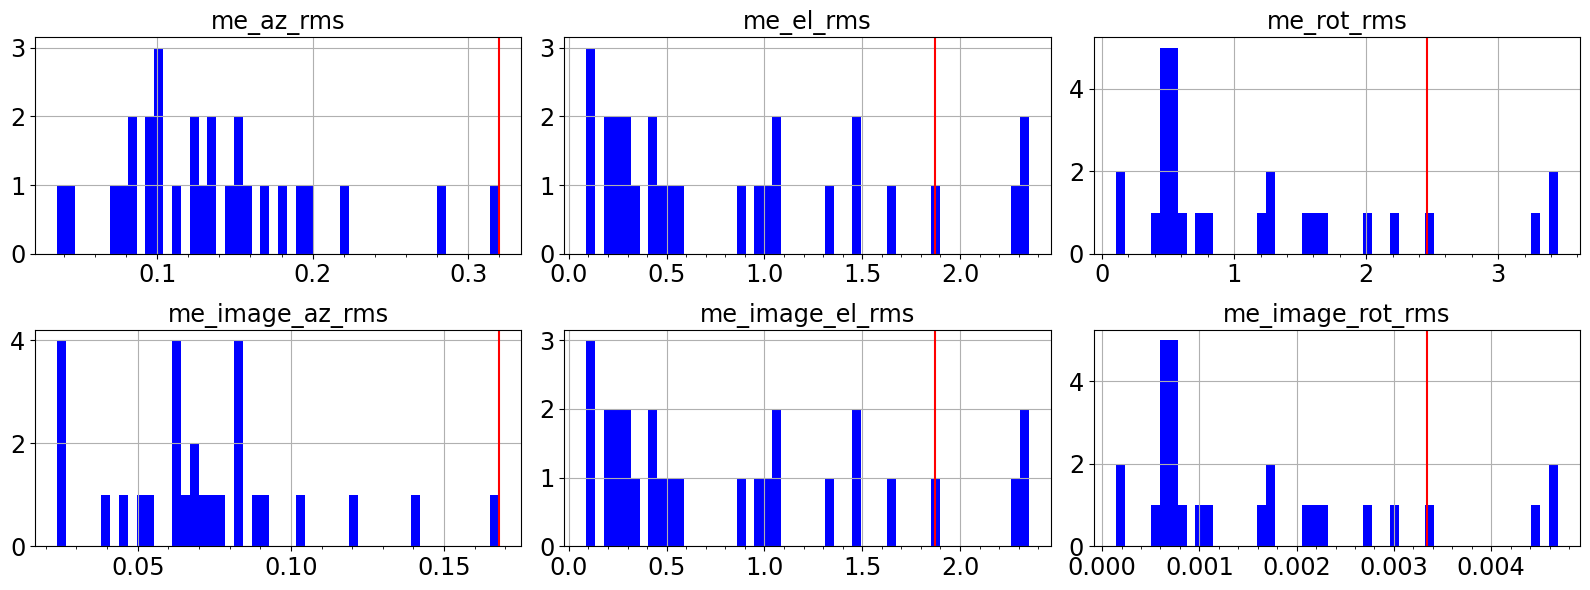

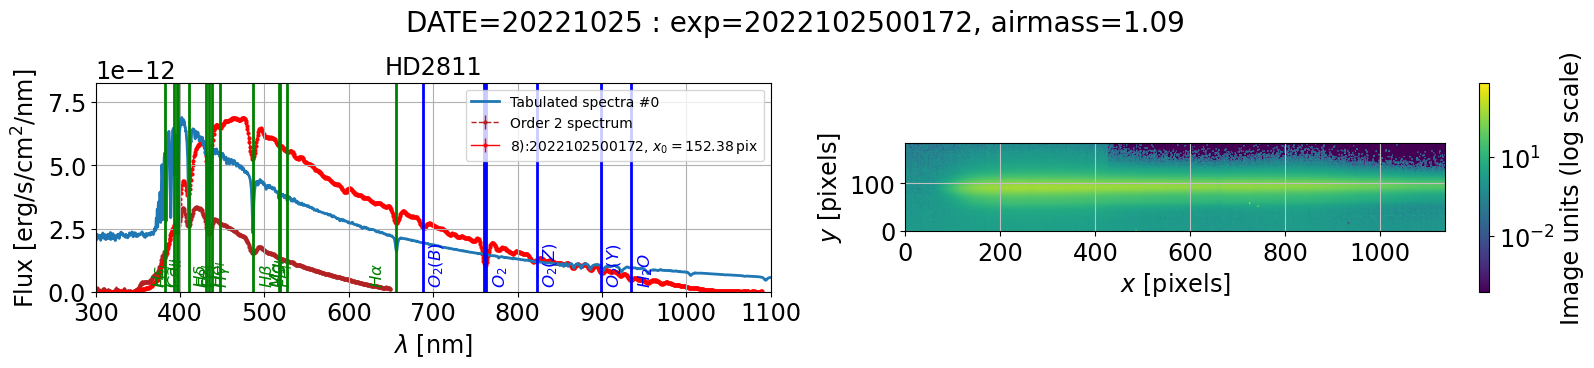

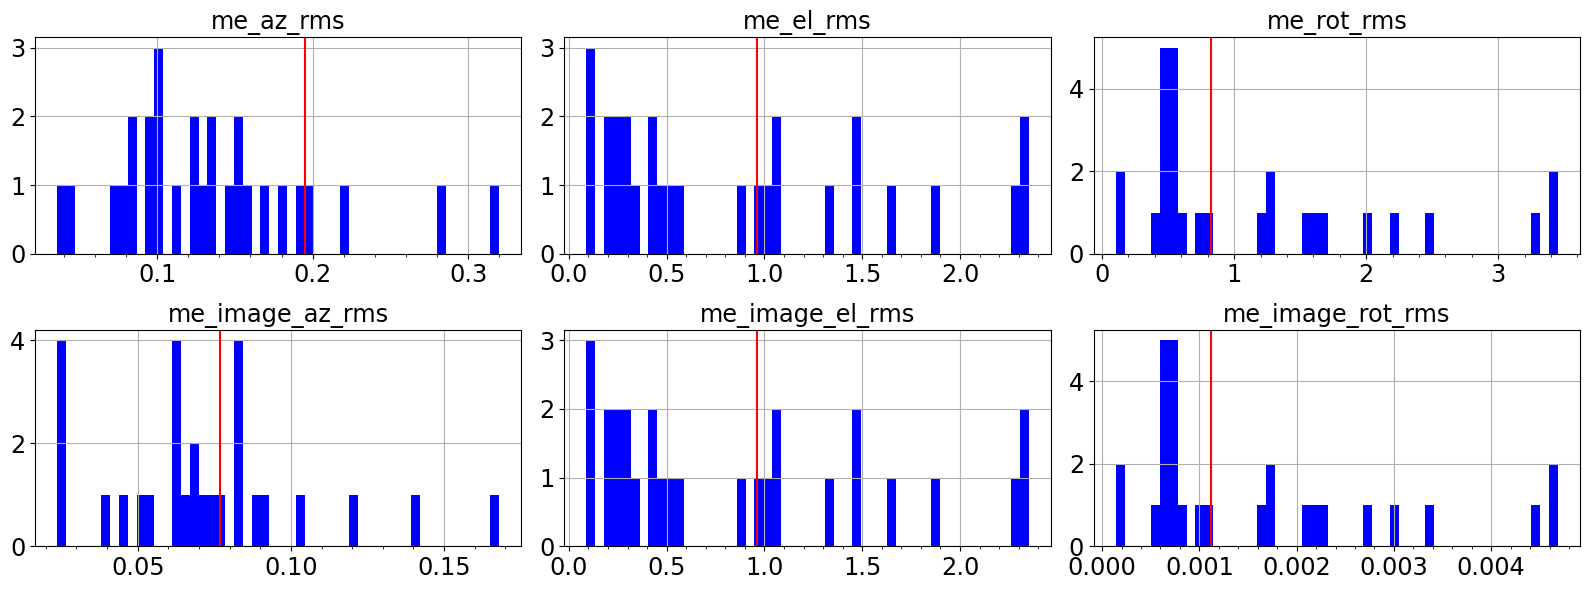

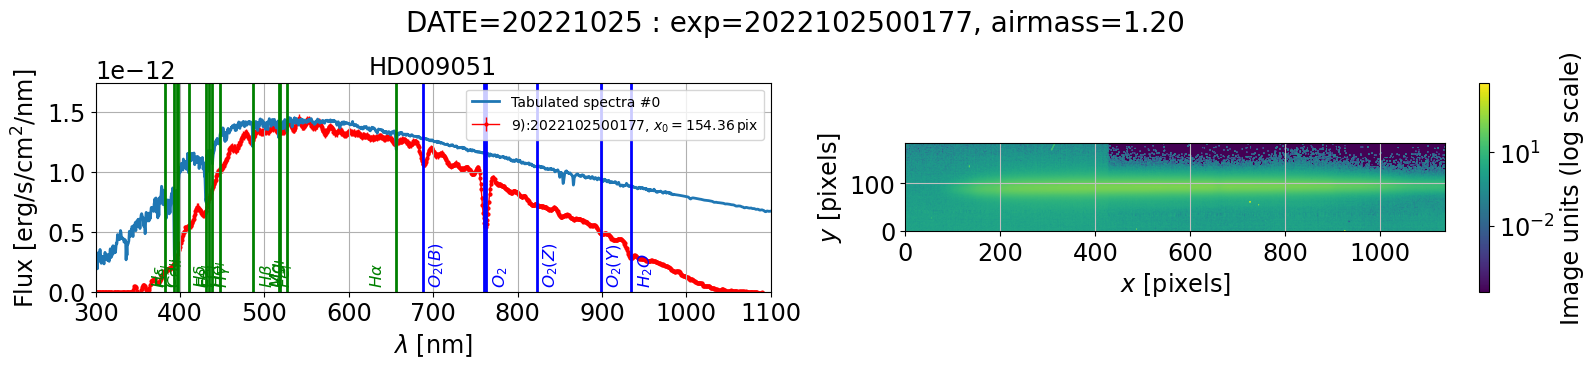

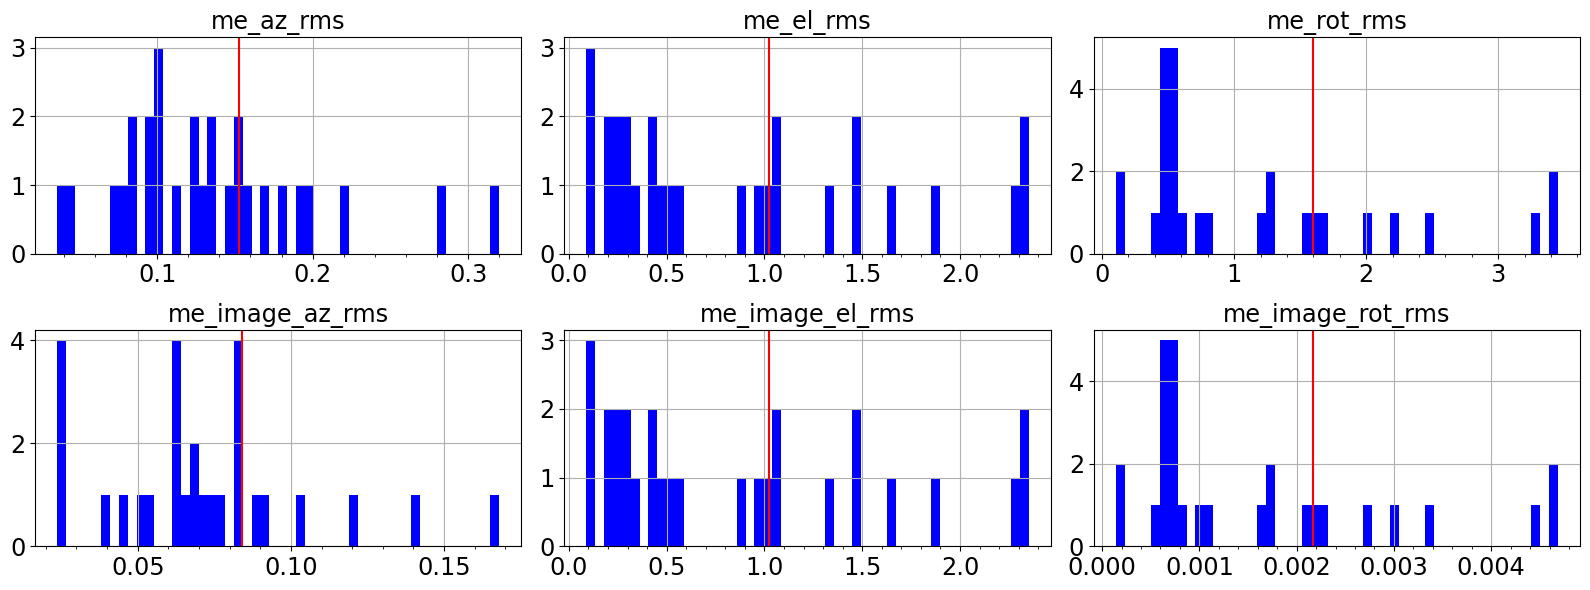

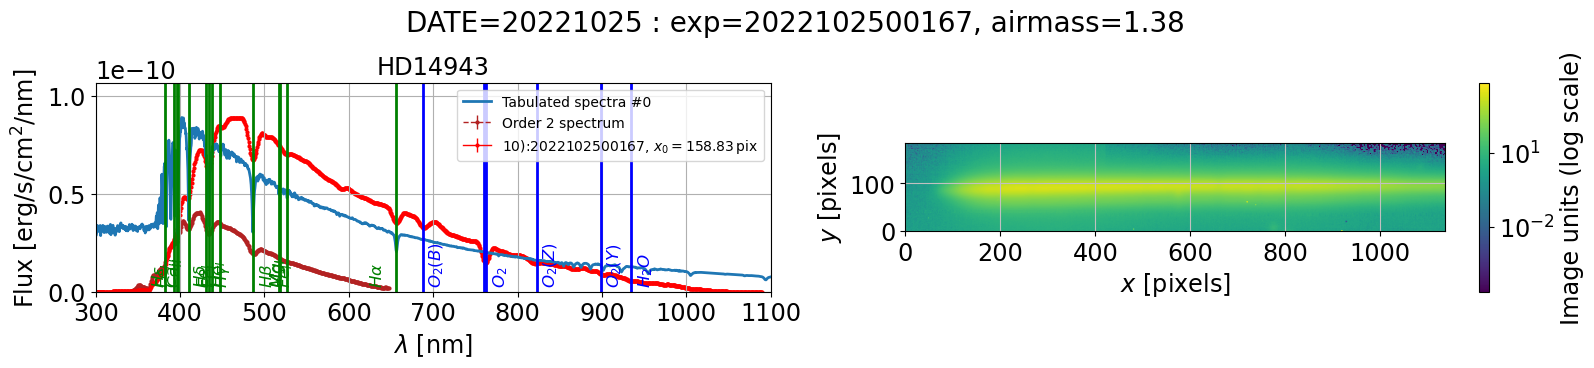

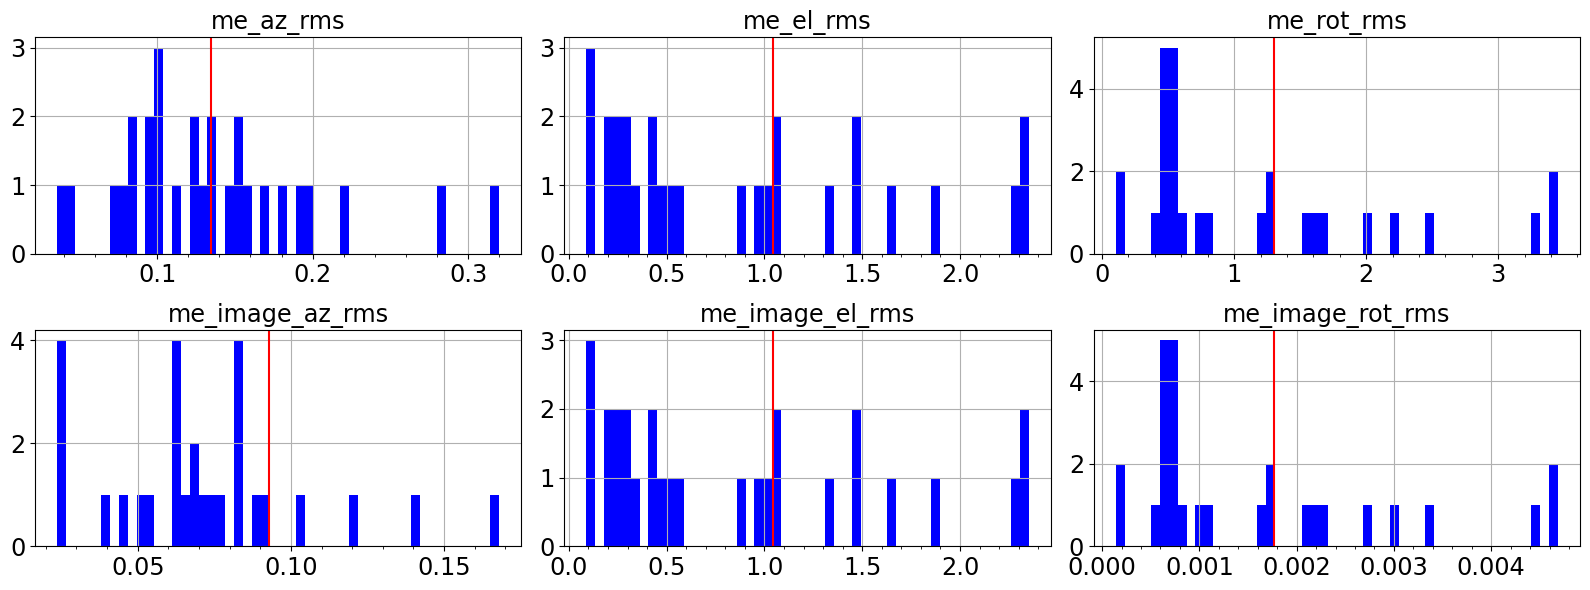

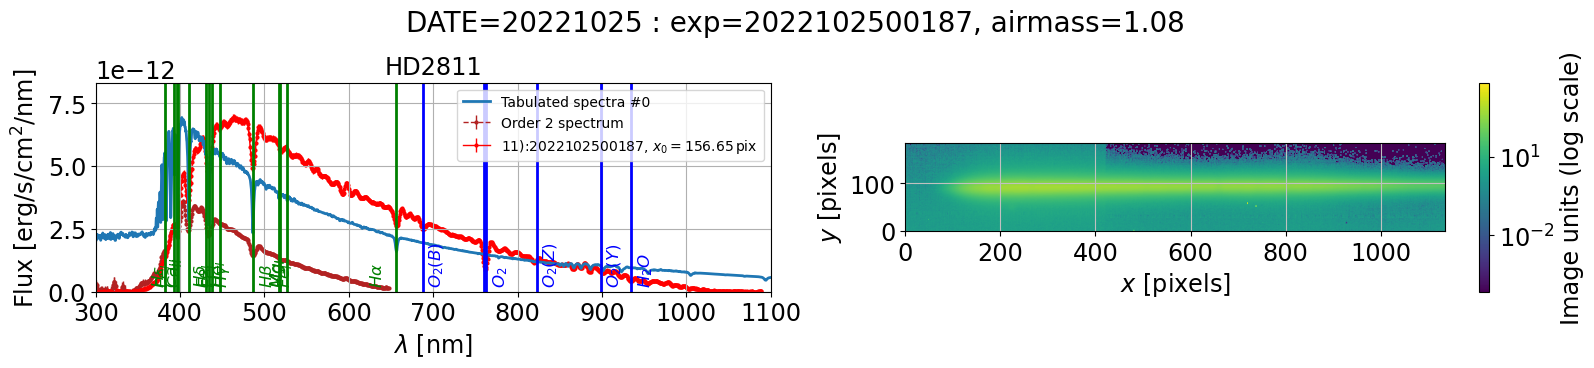

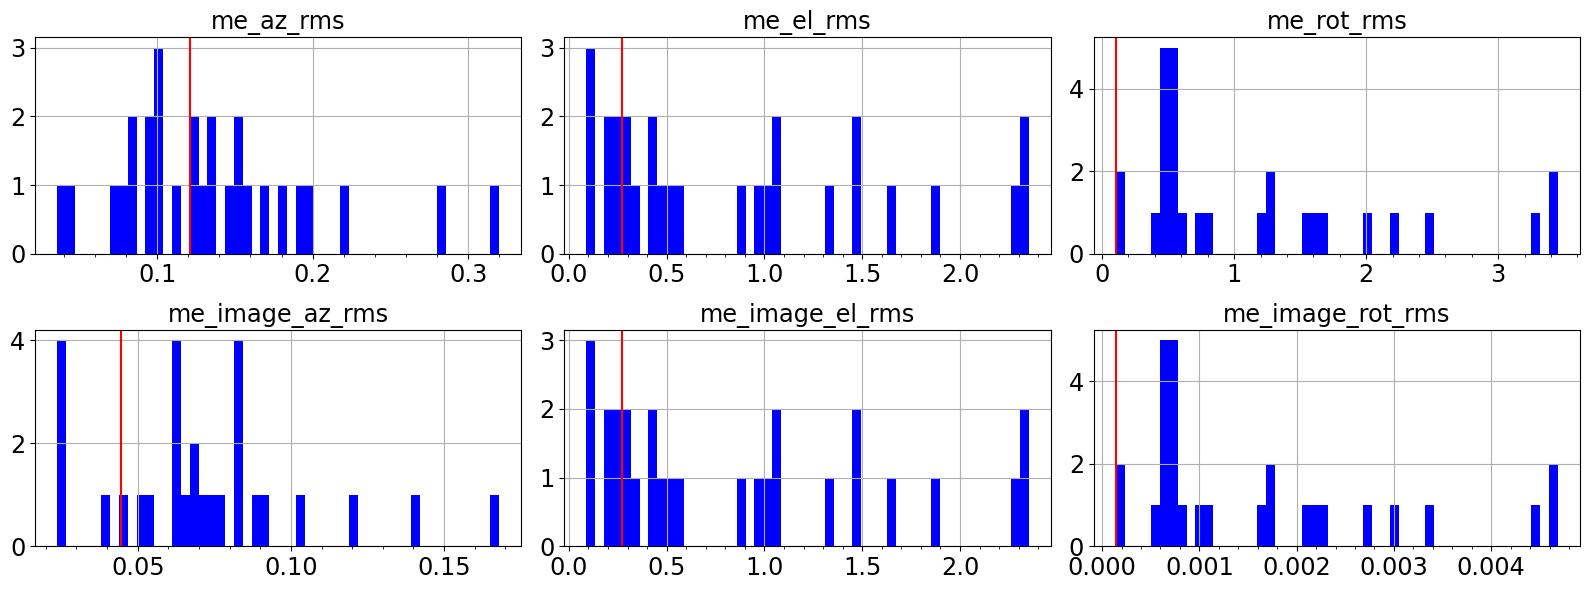

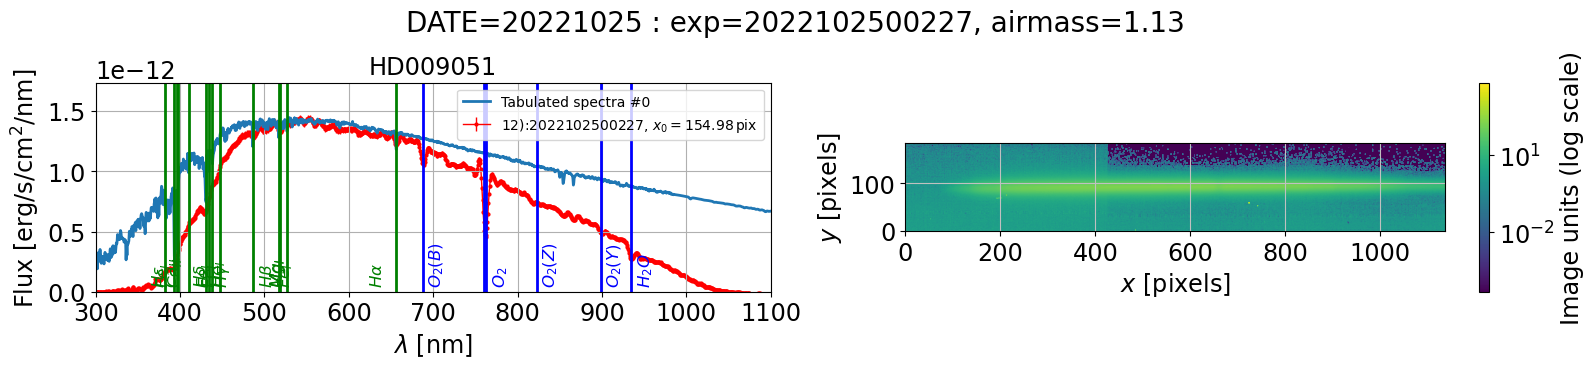

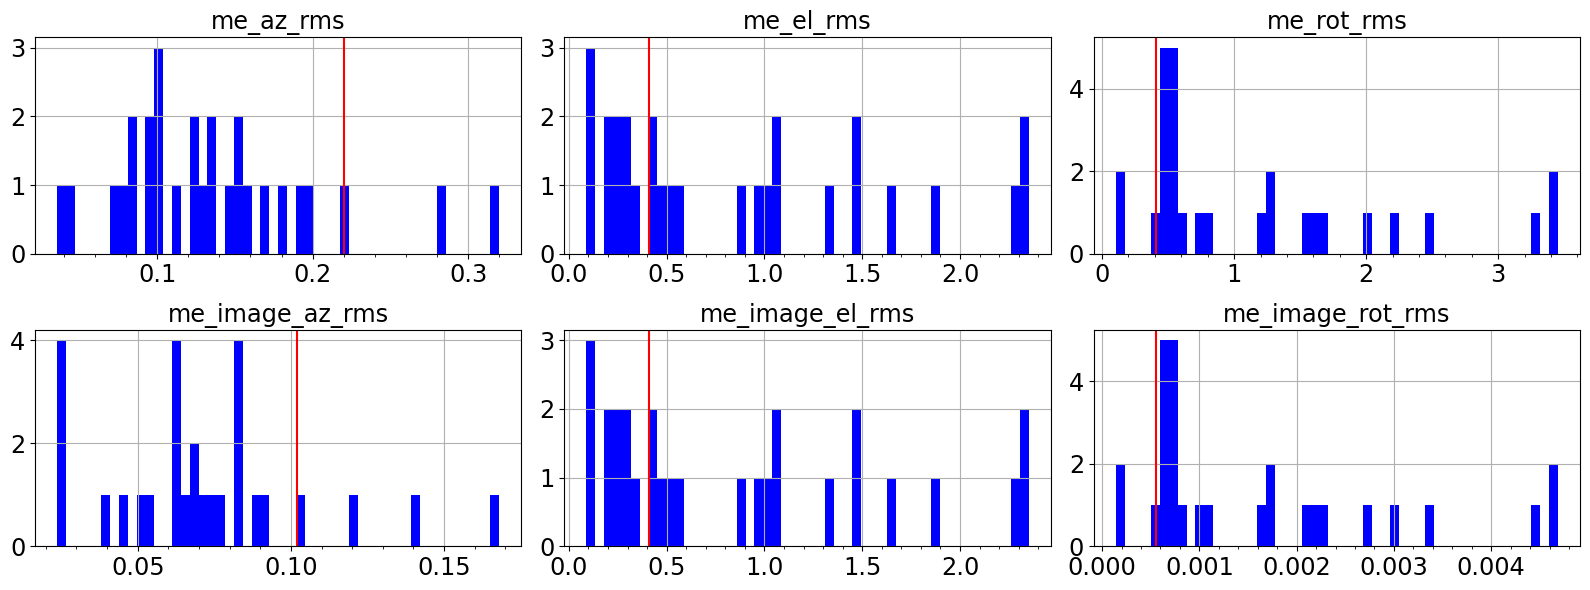

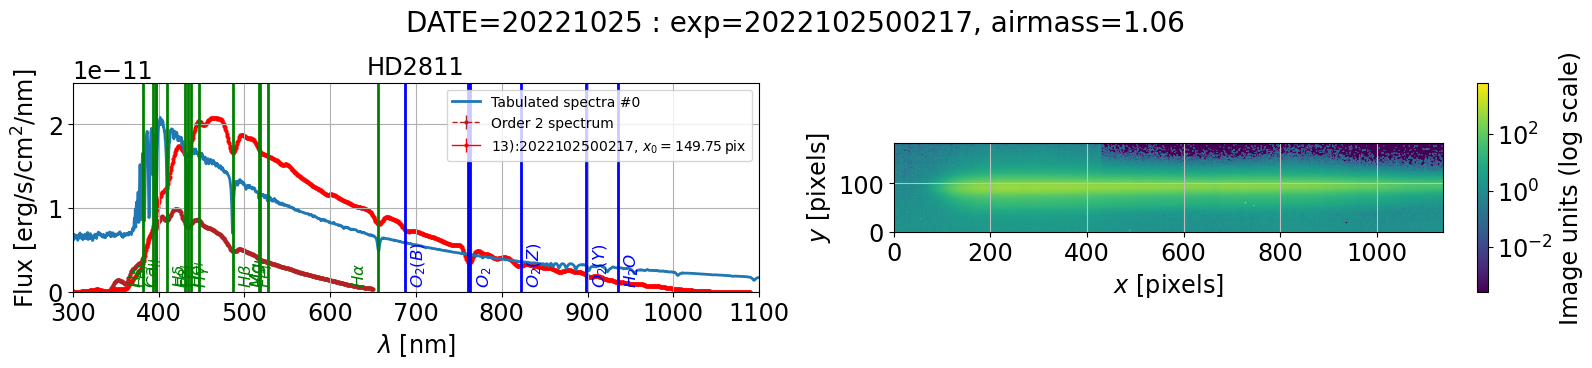

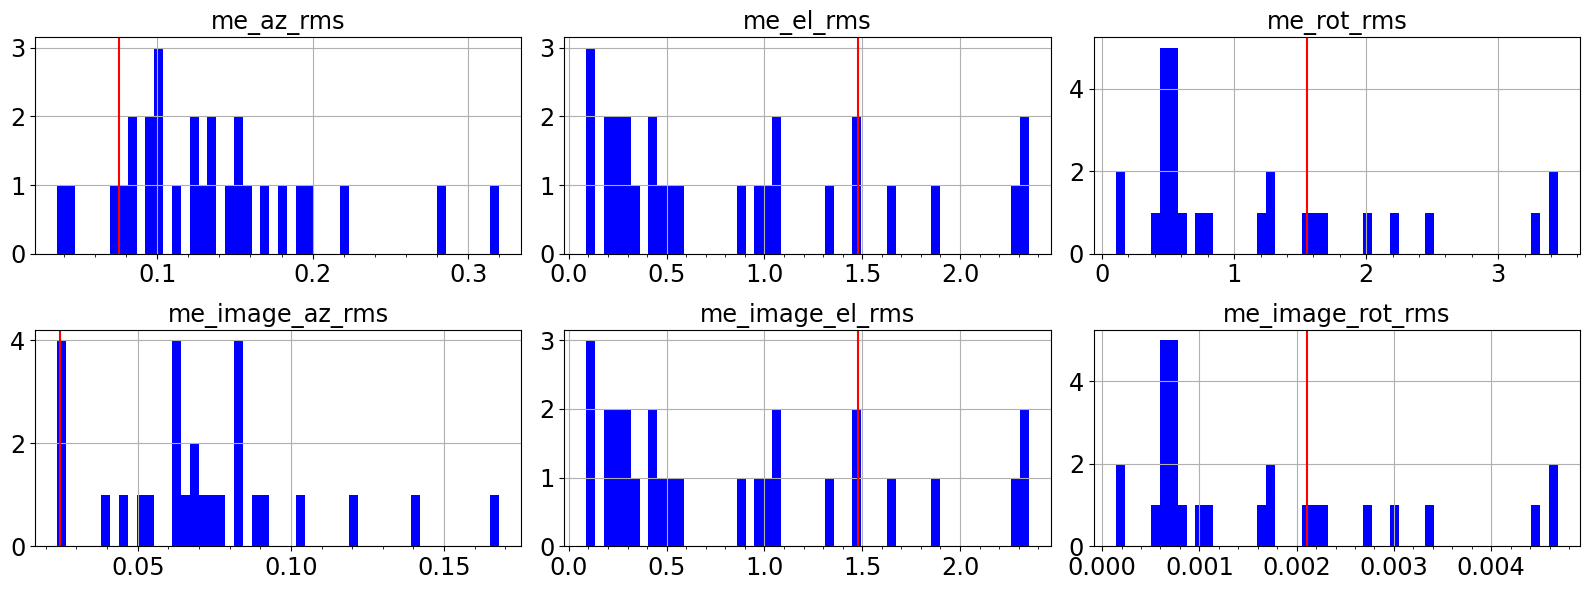

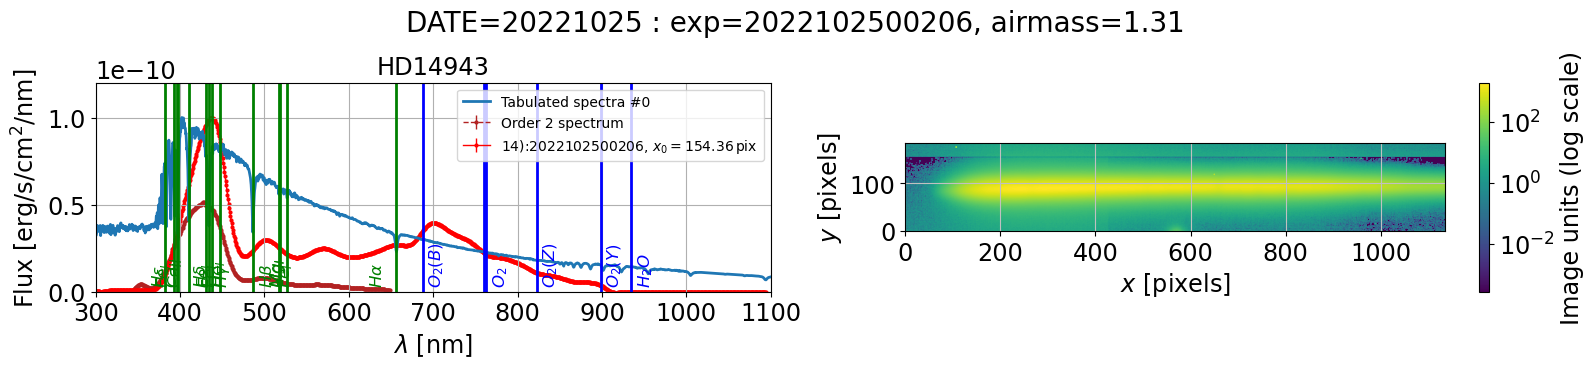

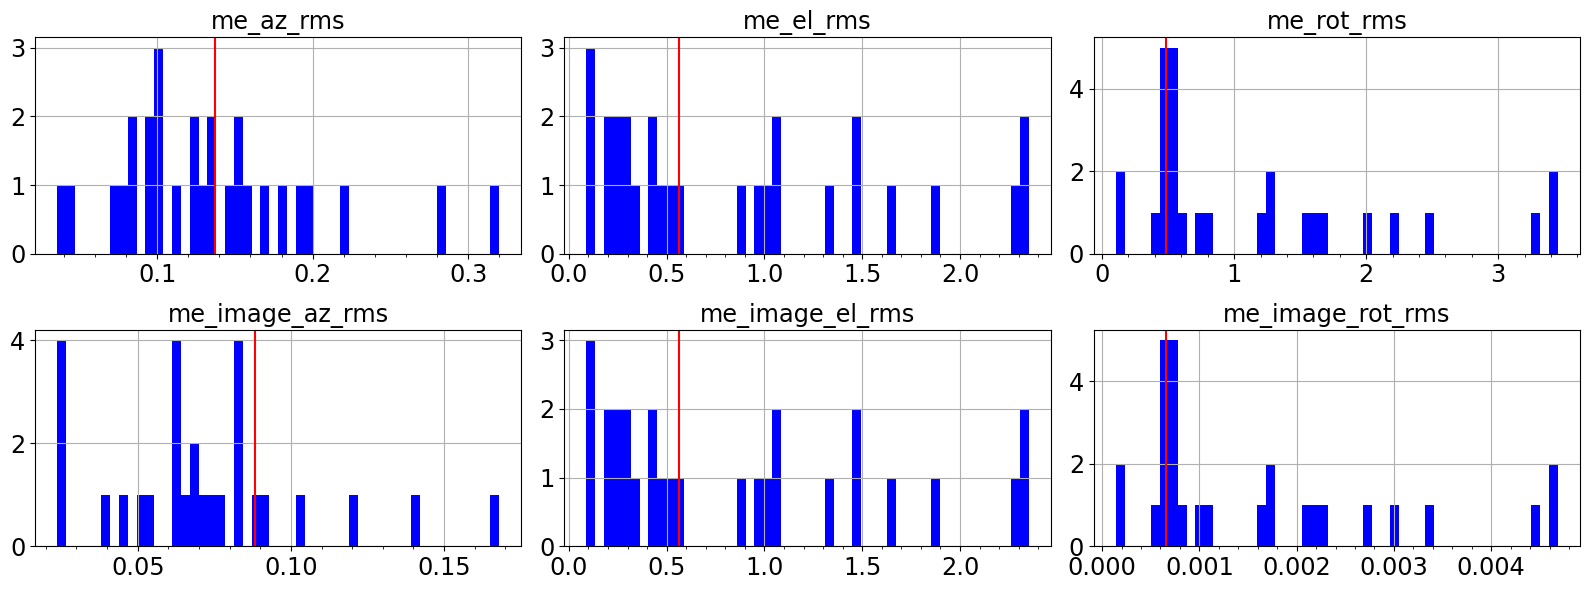

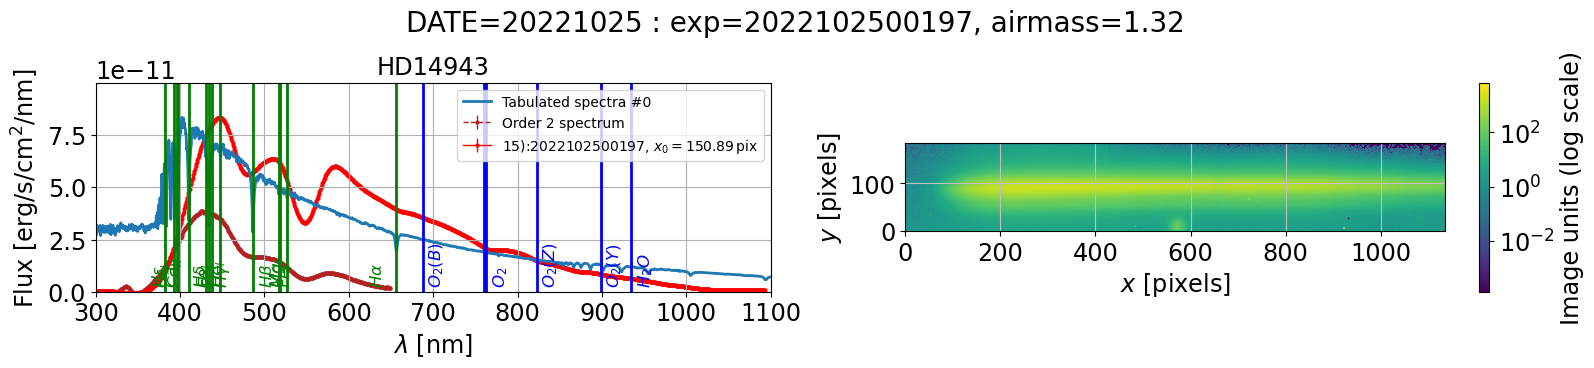

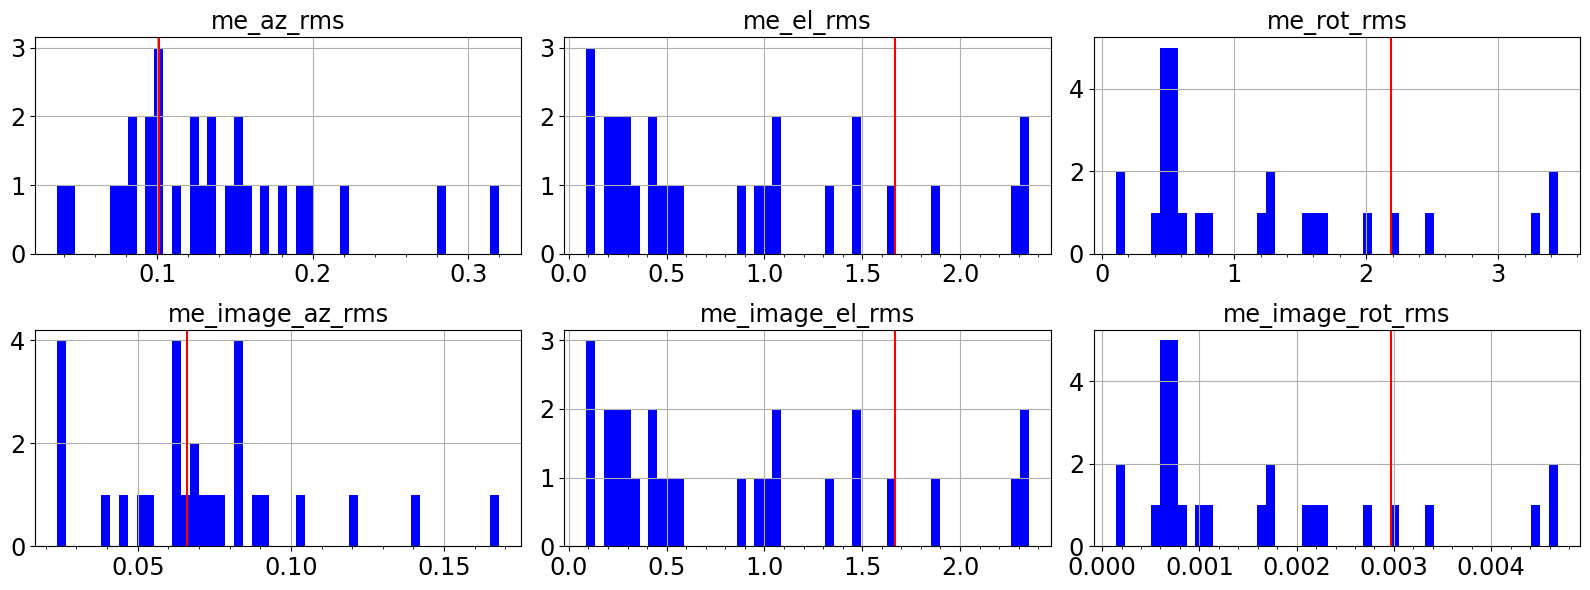

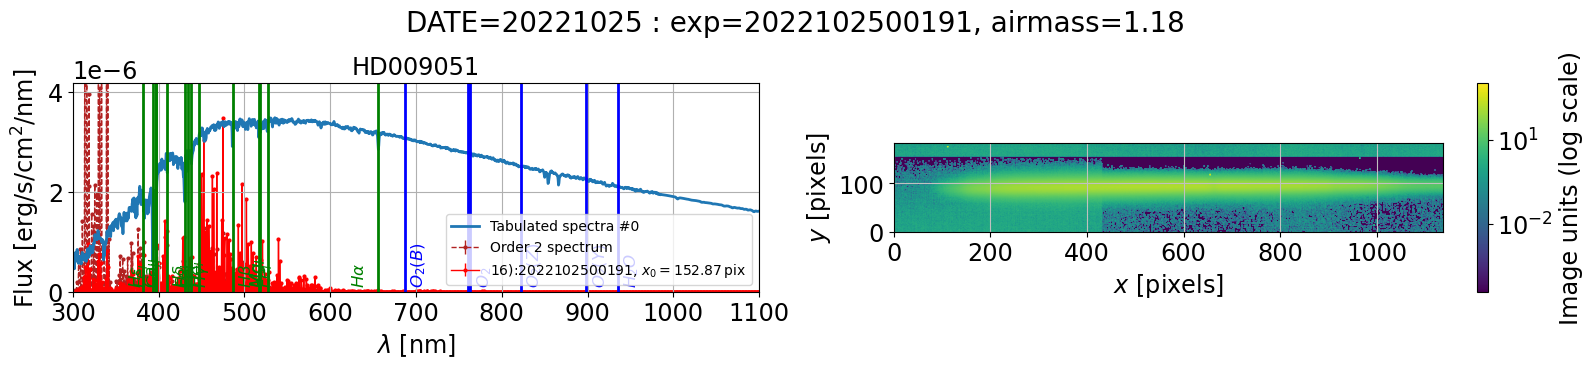

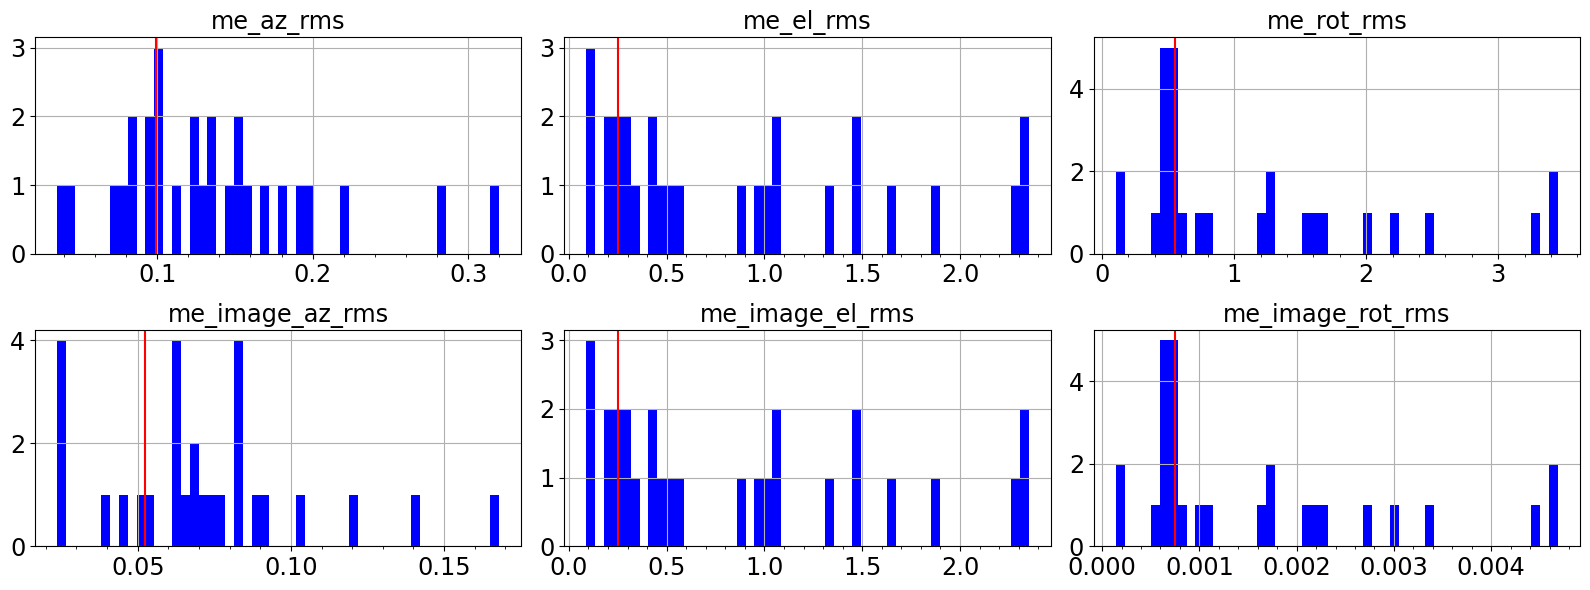

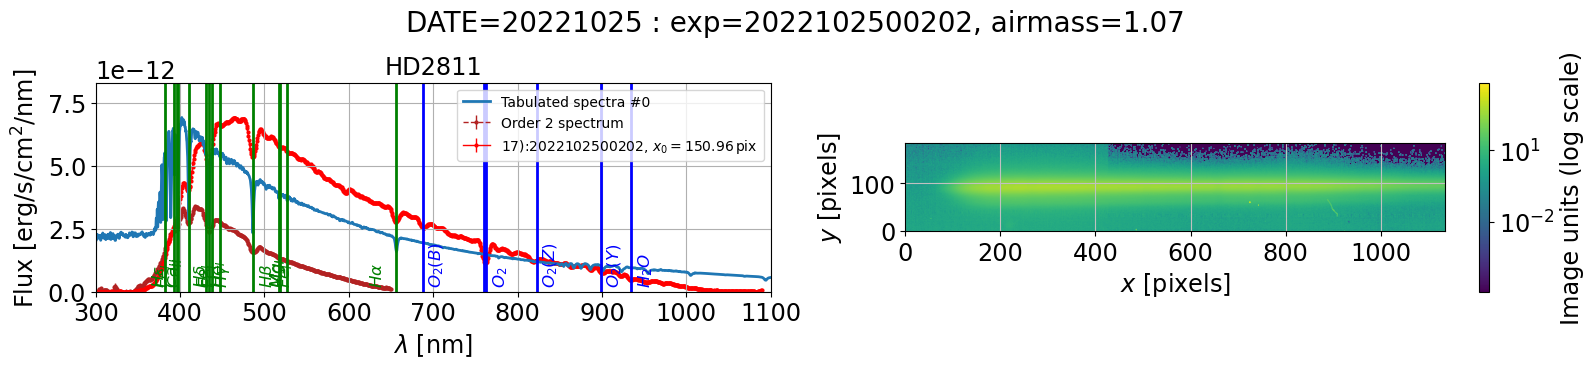

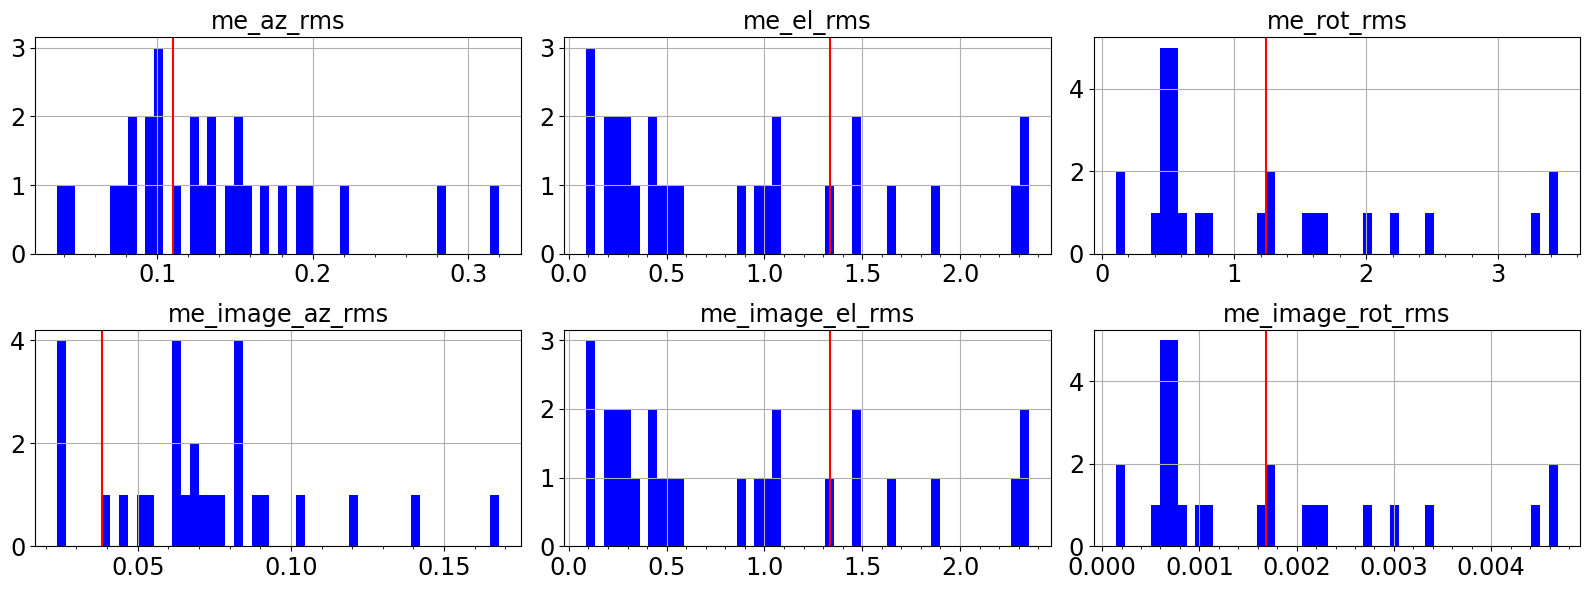

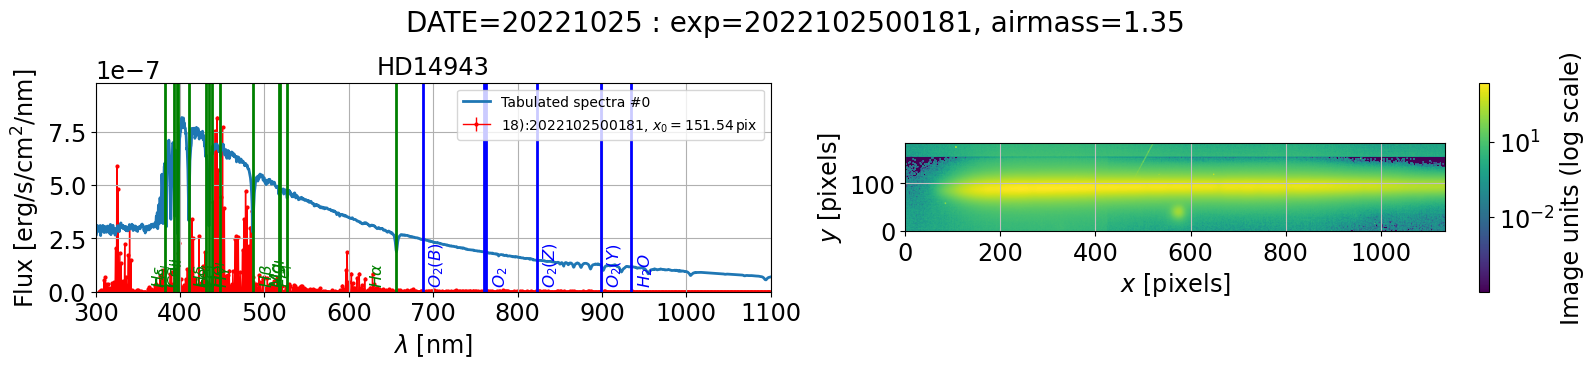

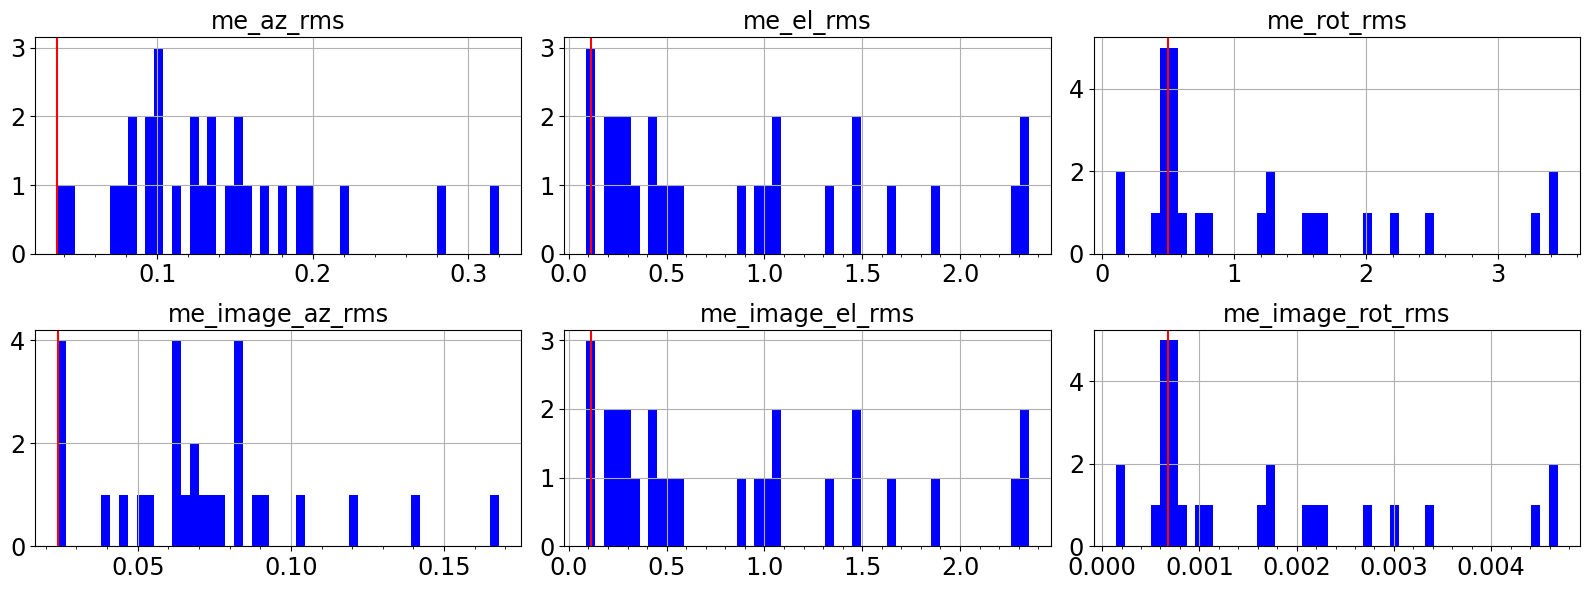

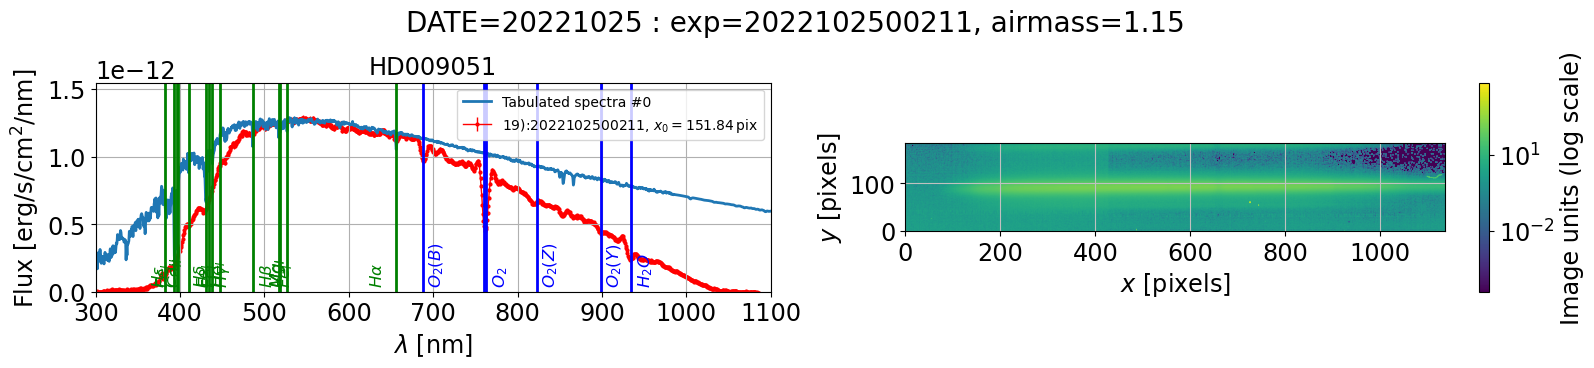

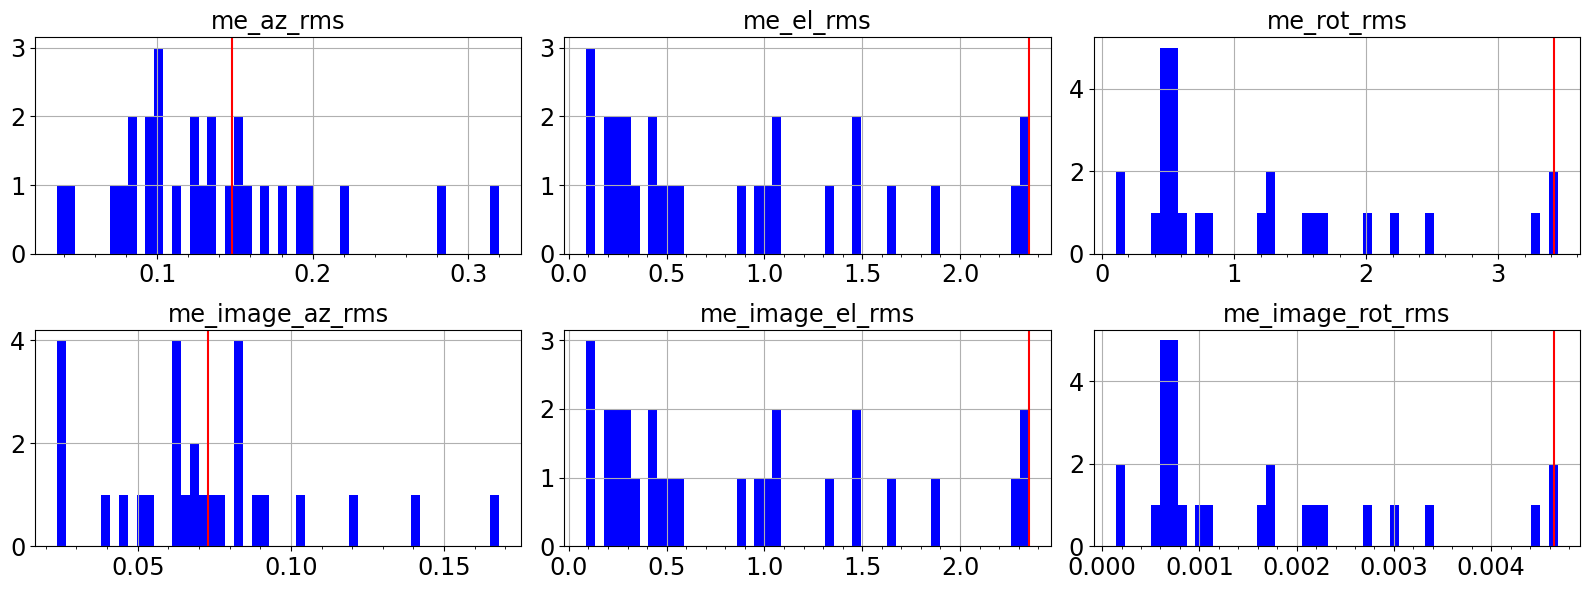

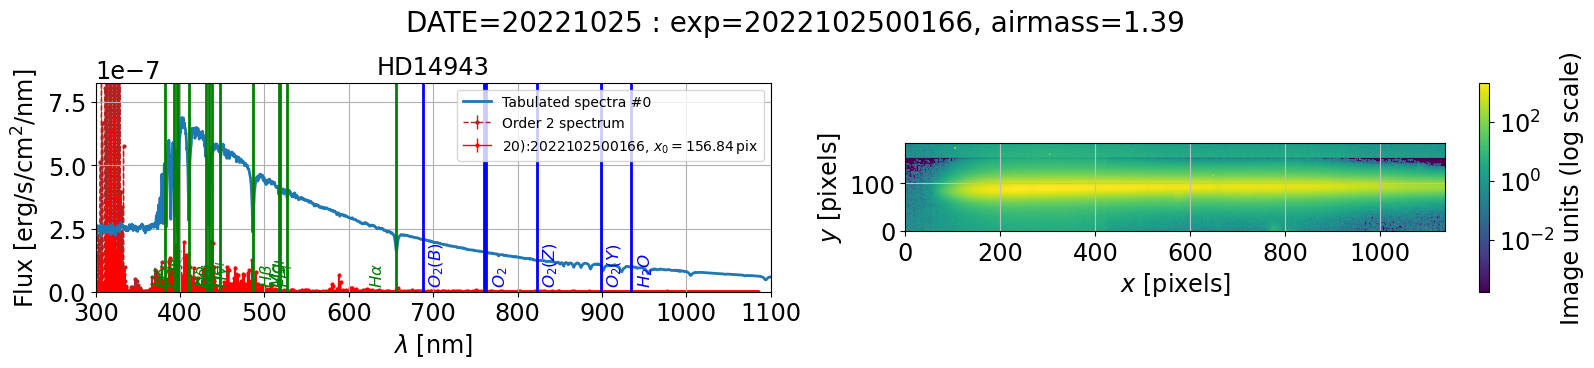

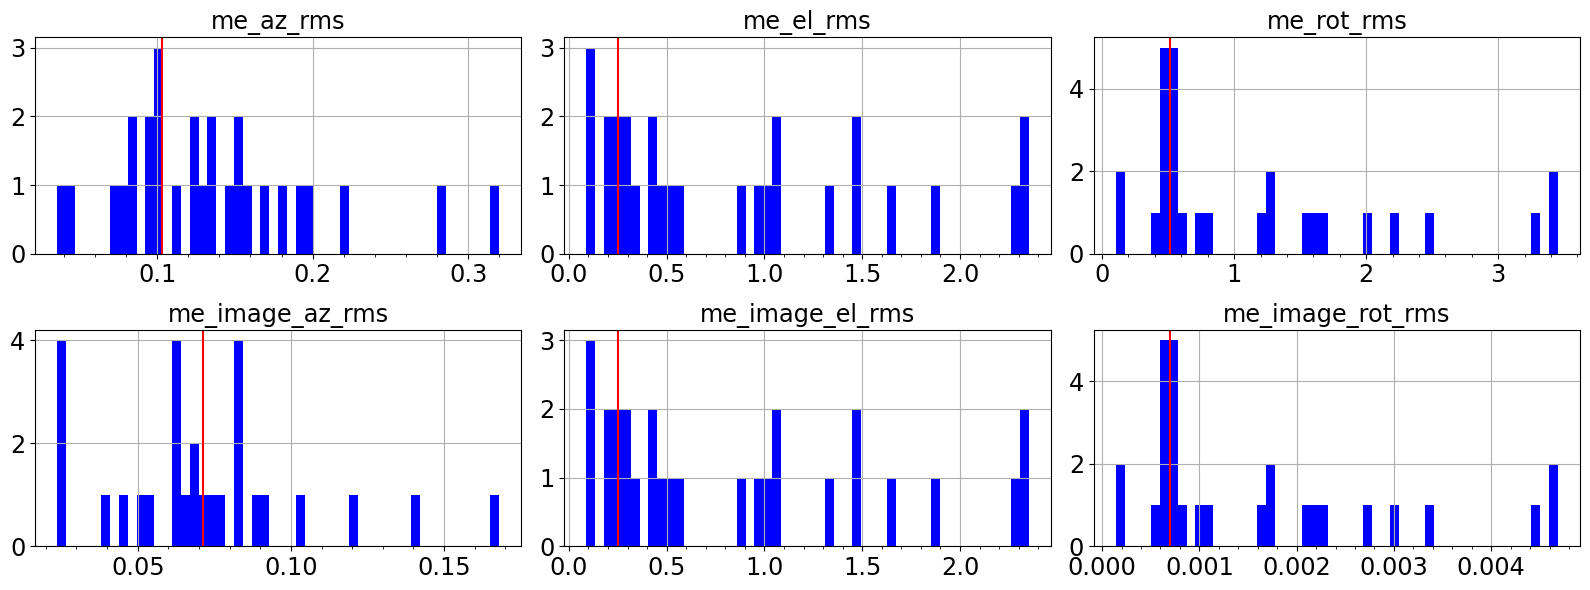

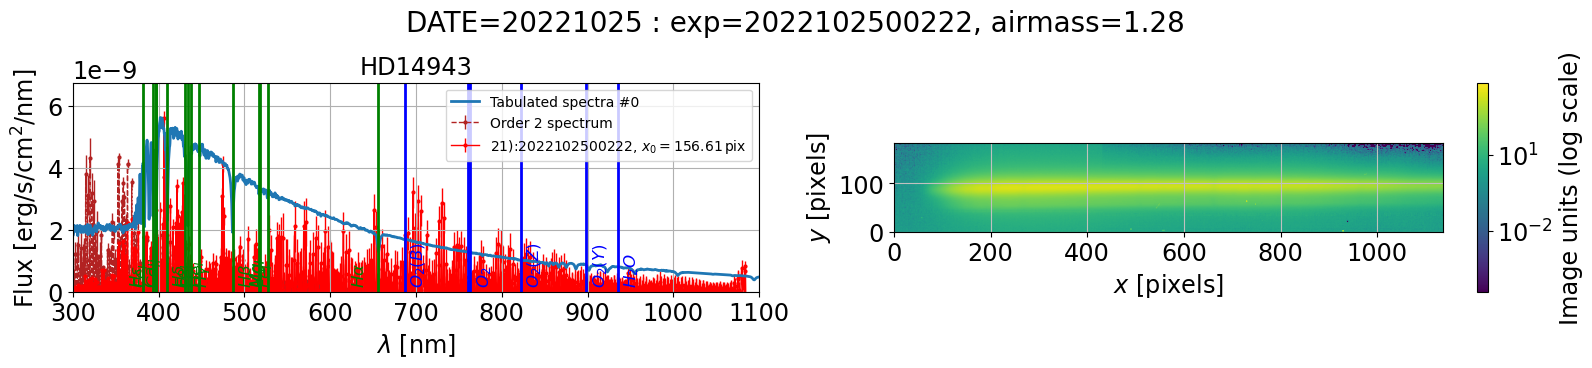

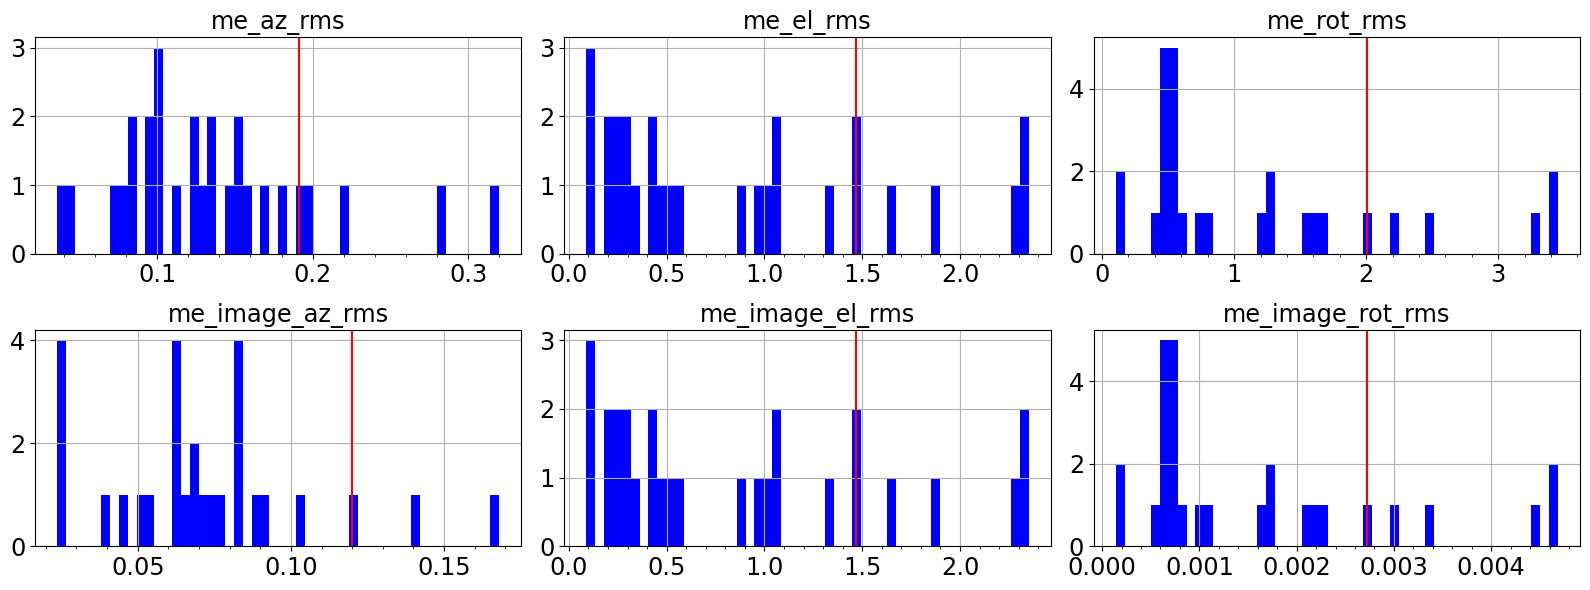

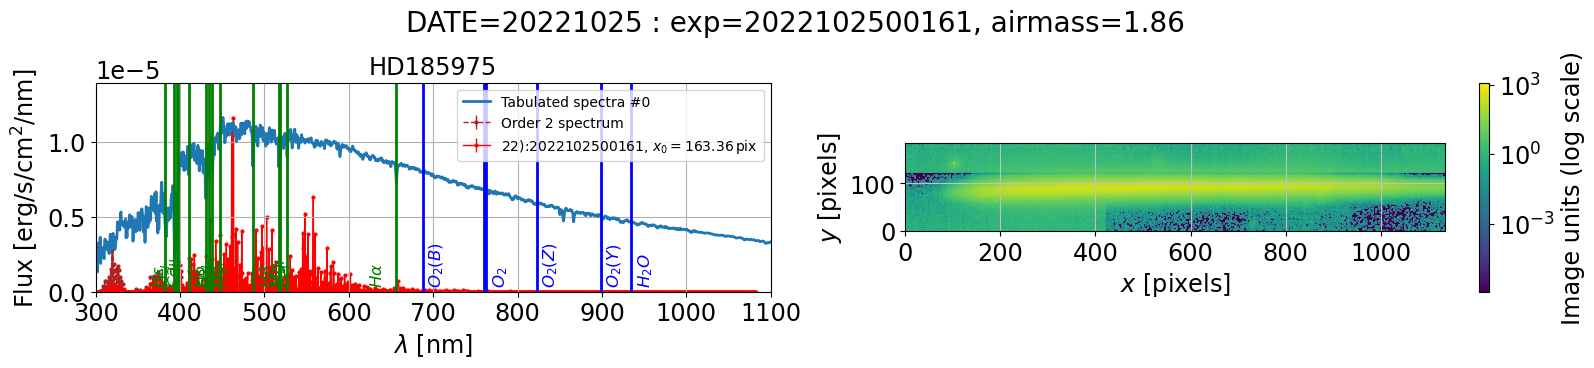

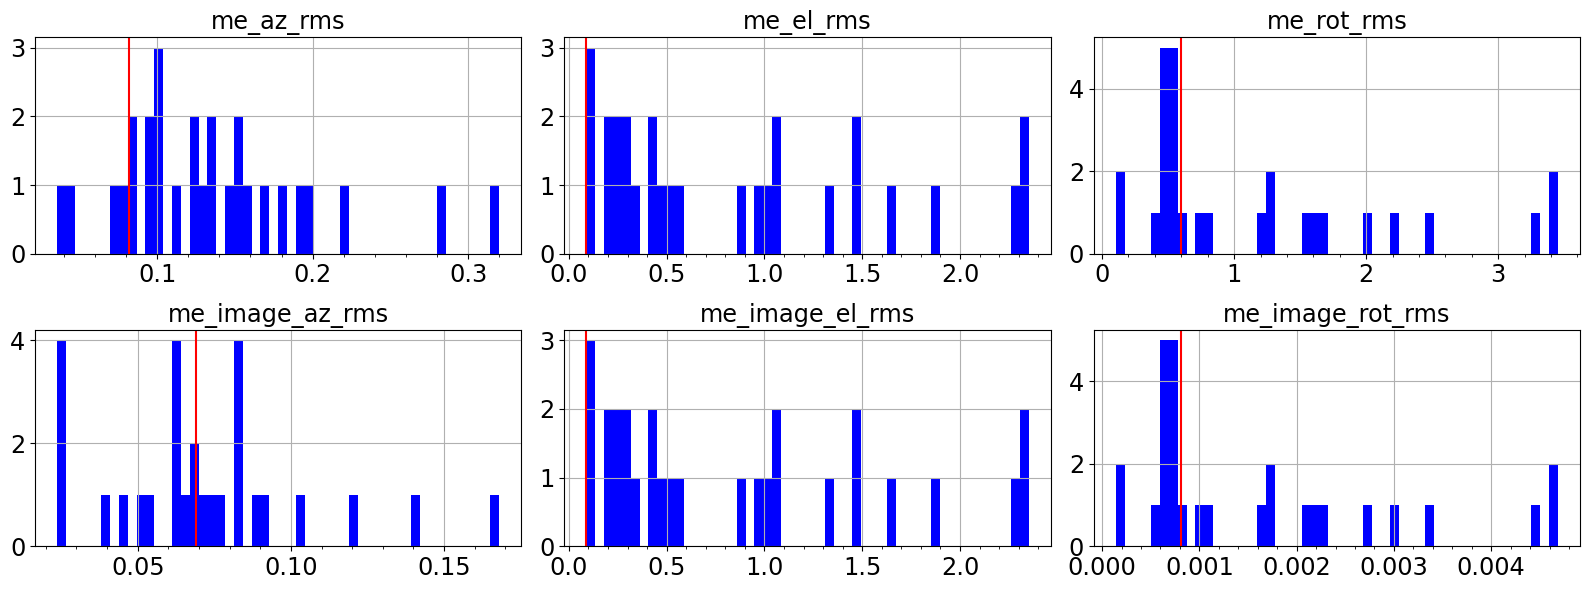

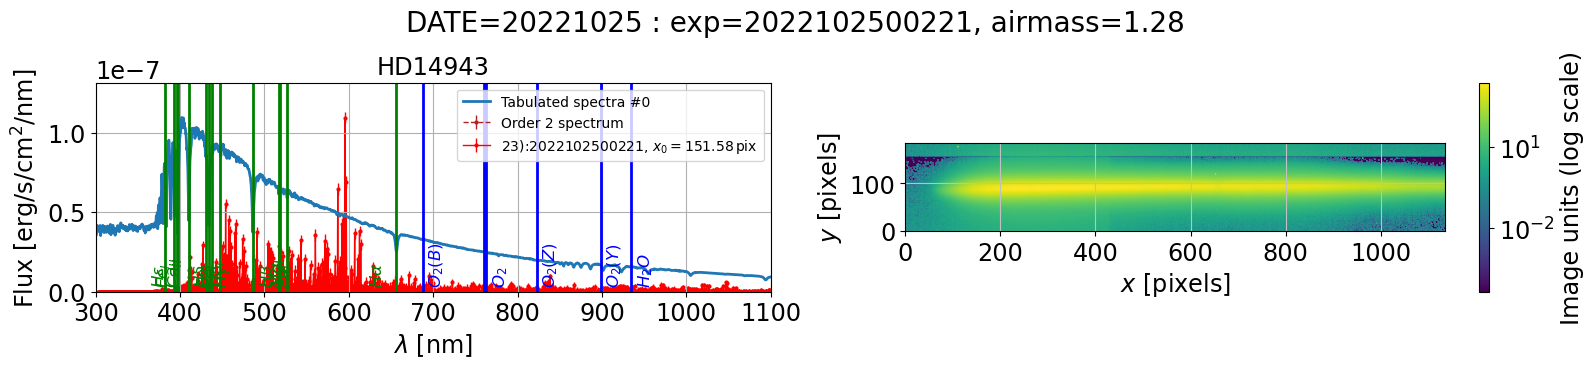

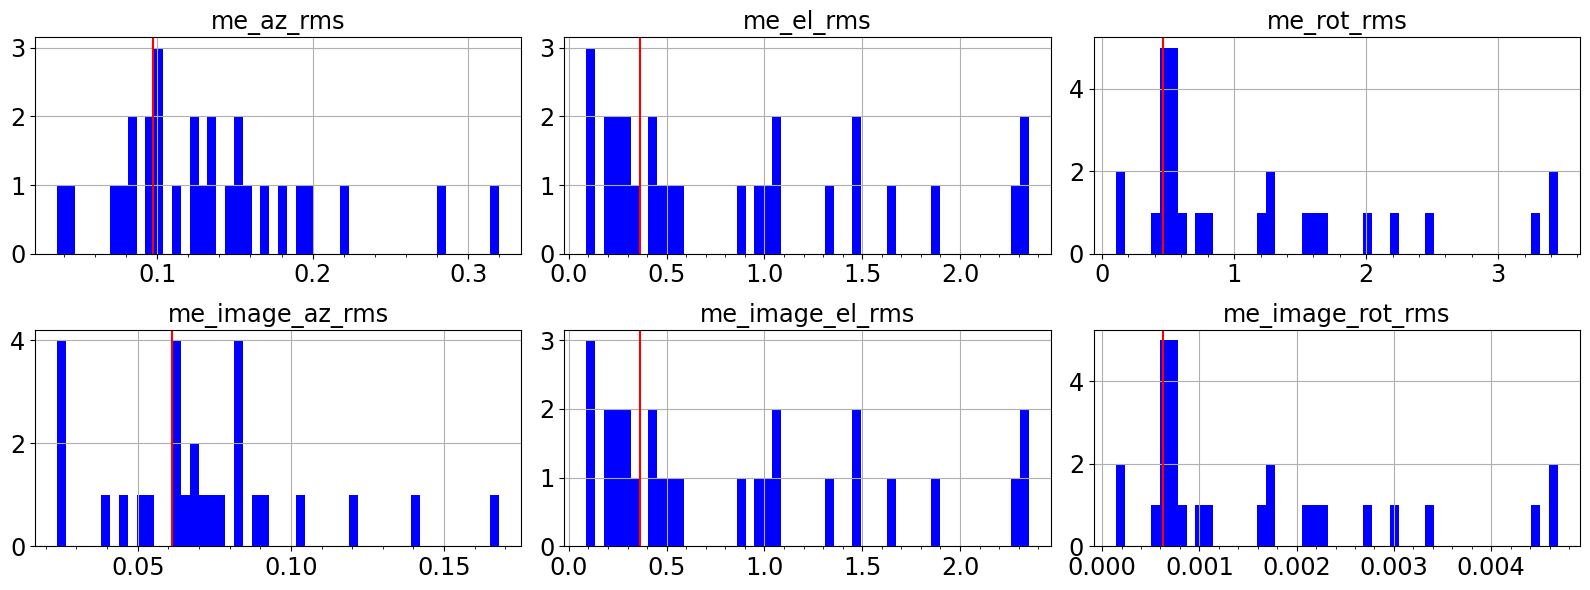

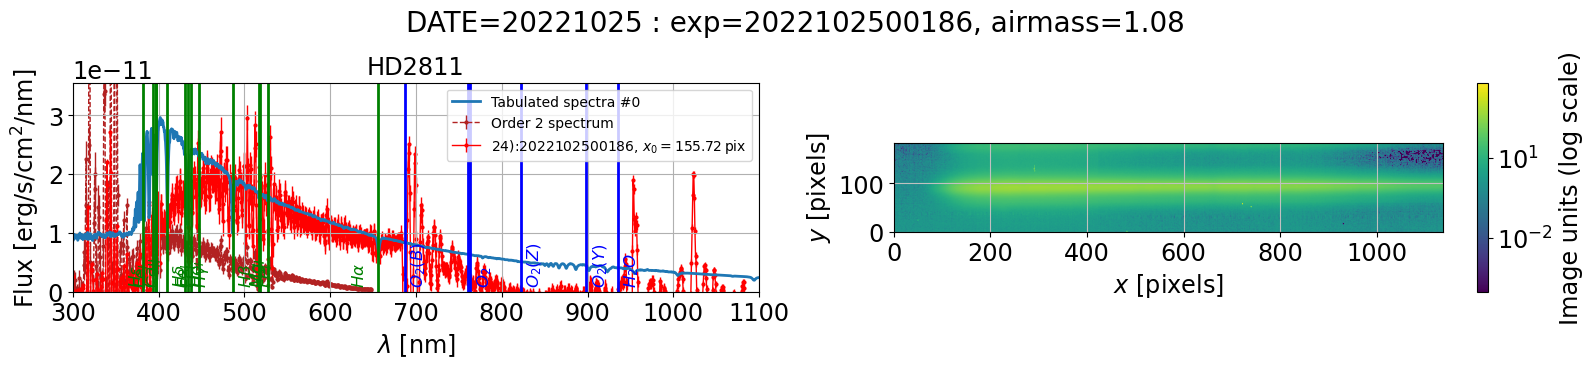

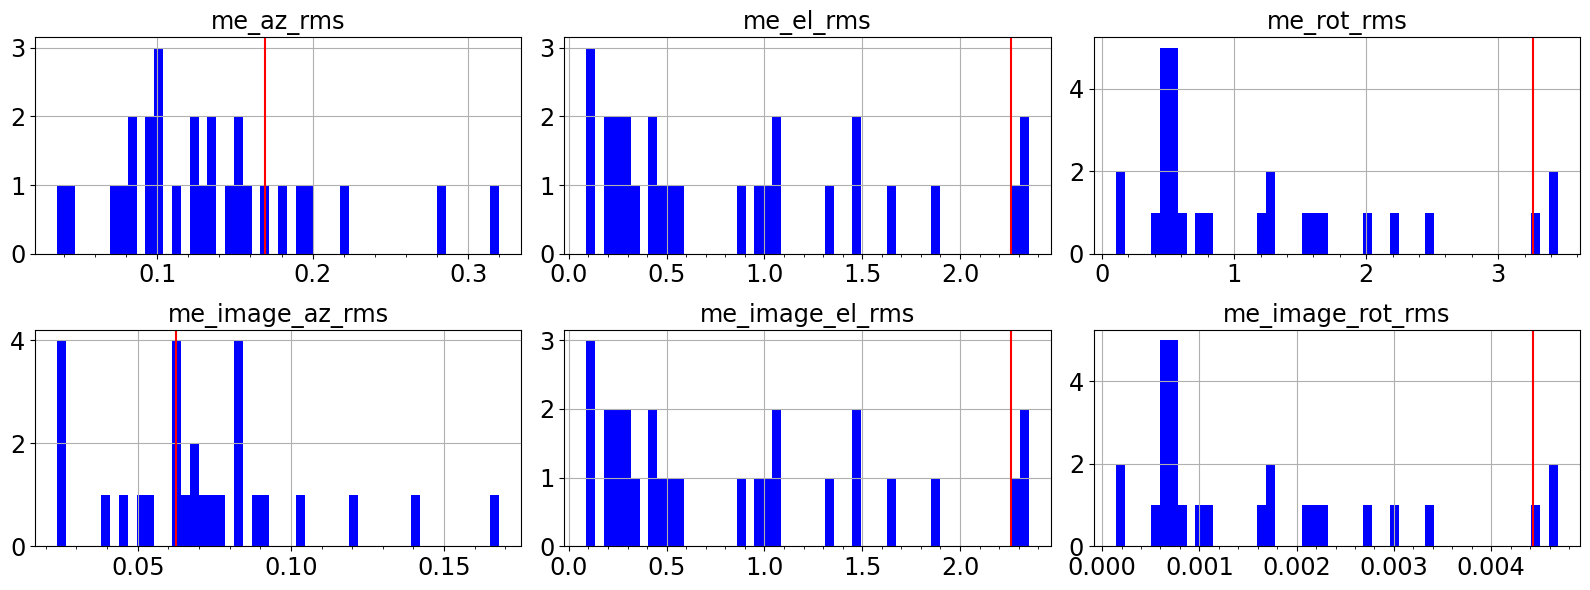

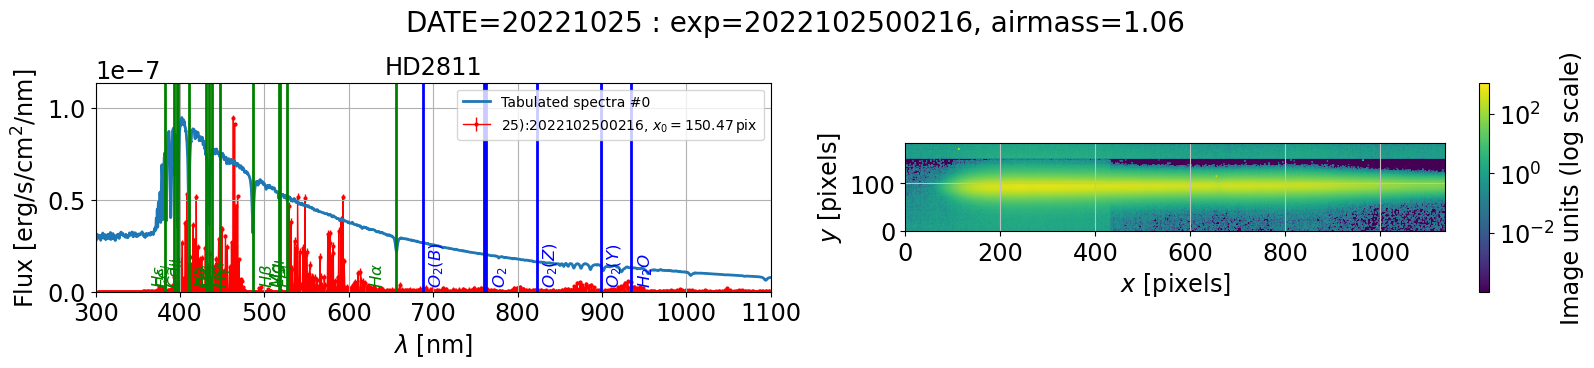

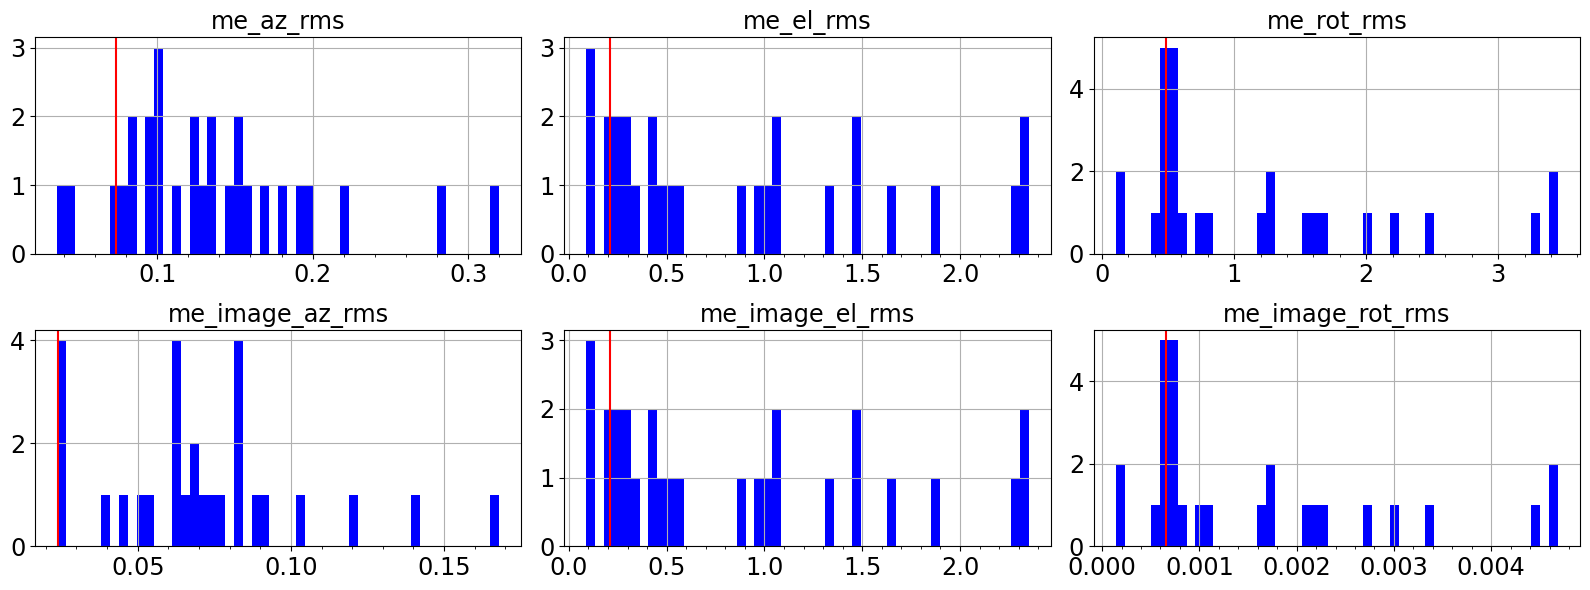

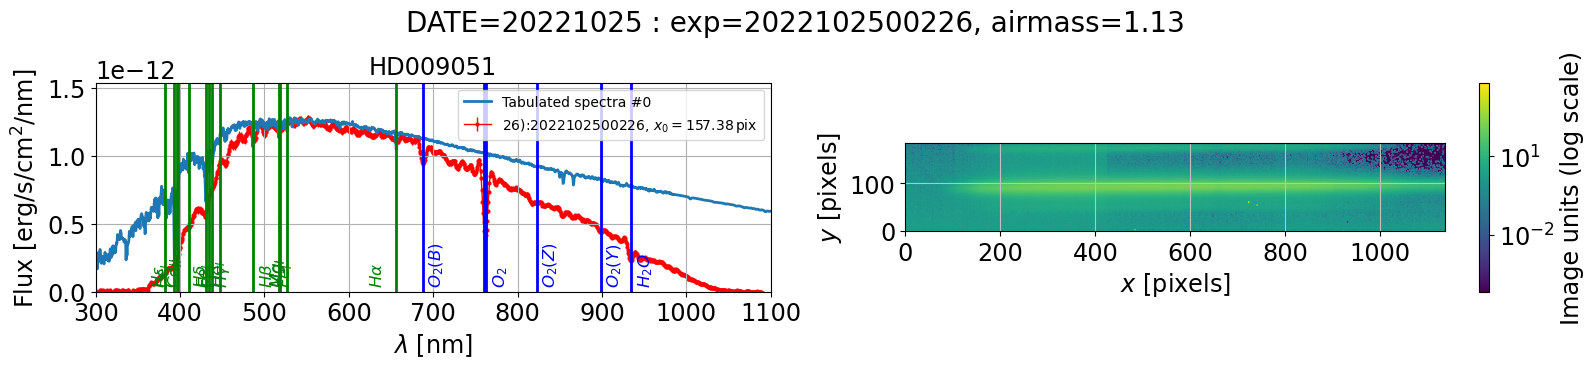

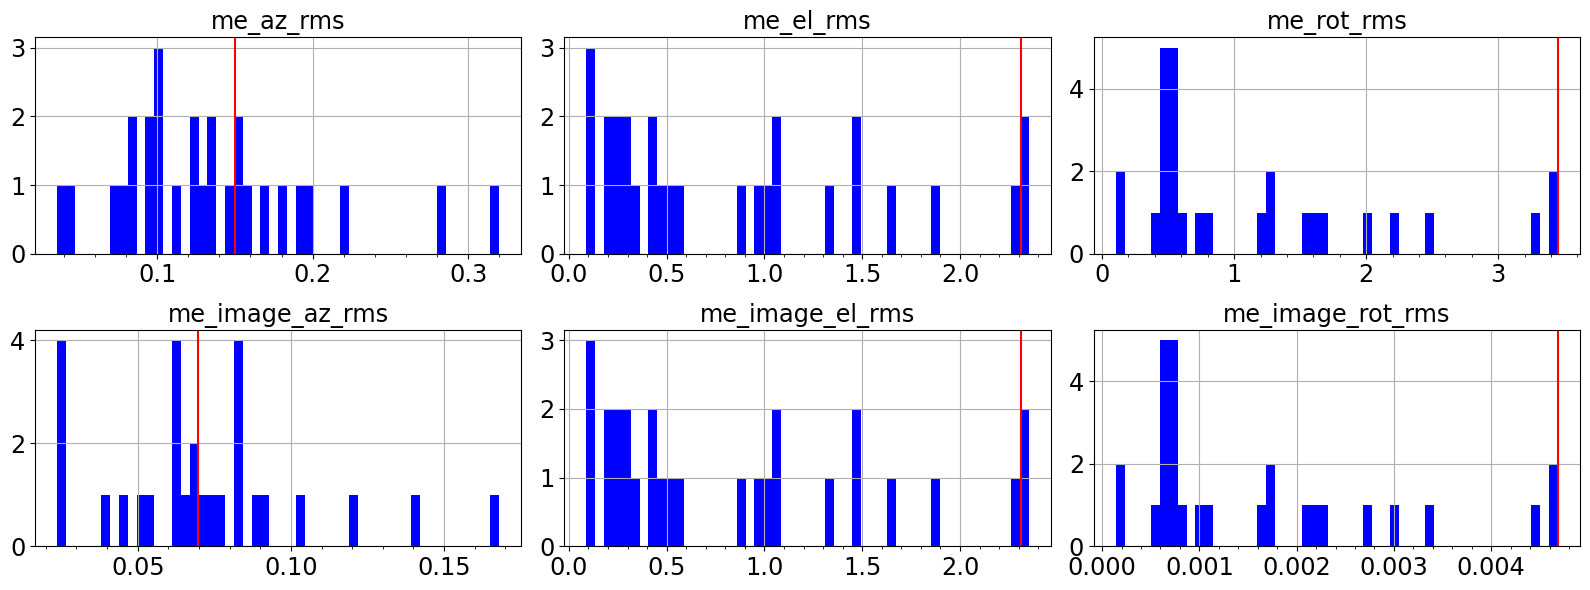

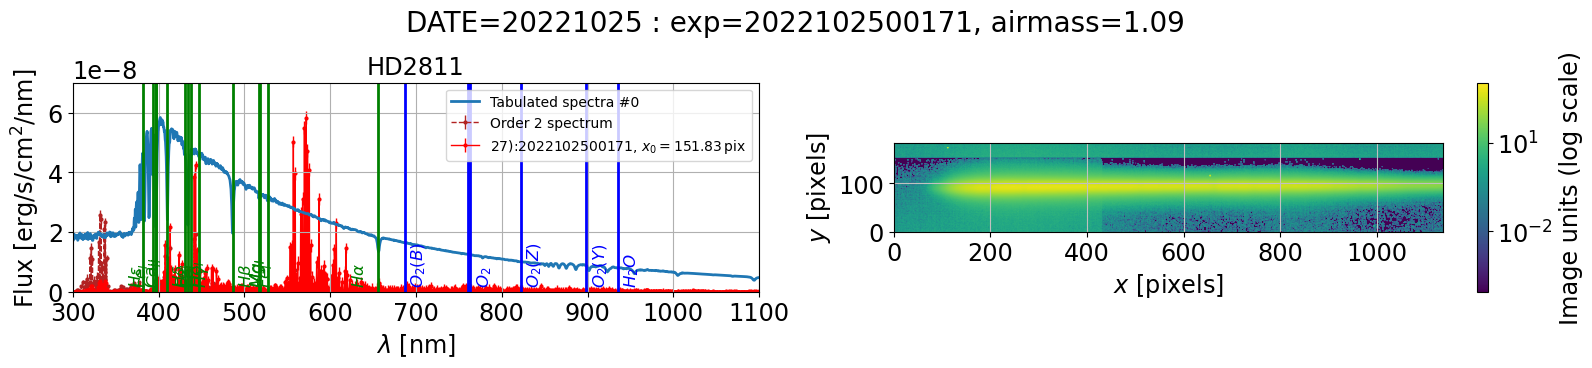

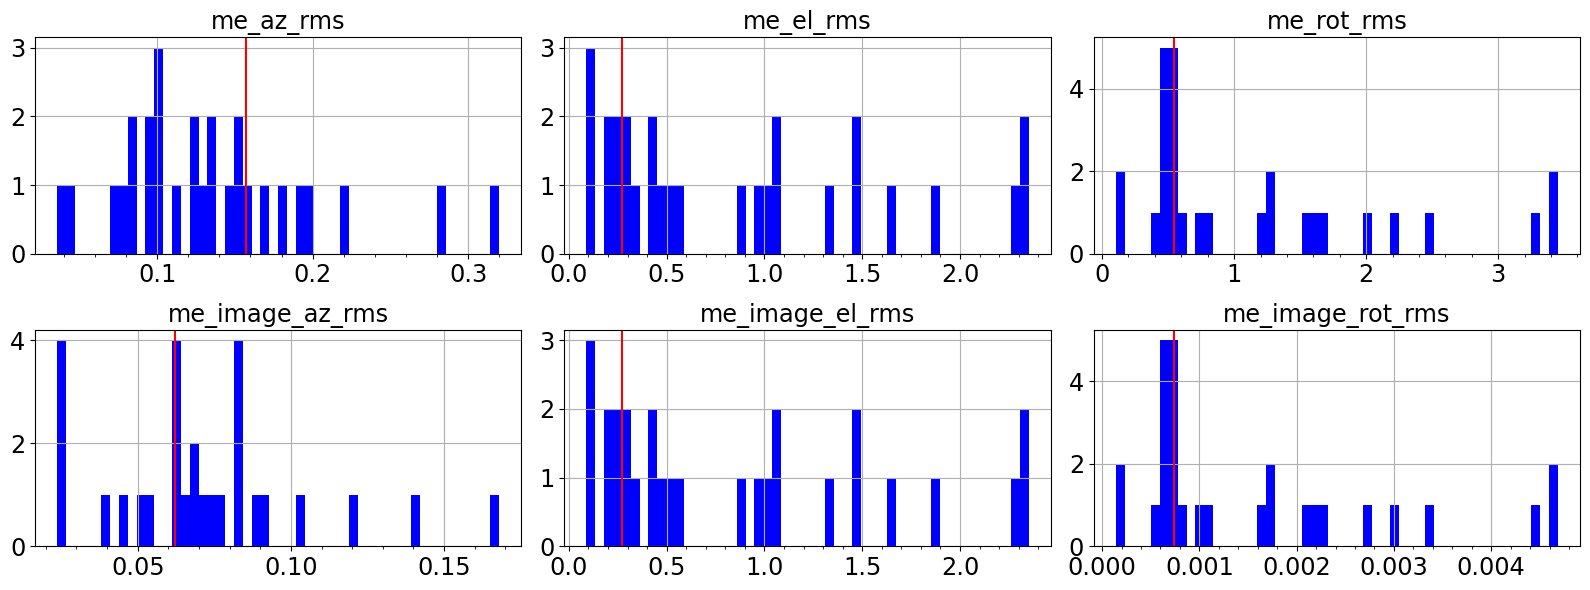

In [34]:
%matplotlib inline


infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]


idx=0
for spec in all_spec:
    
    
    #s=spec.spectrum
    s=spec
    
    the_exposure = all_exposures[idx]
    
    label = str(idx) +"):" + str(all_exposures[idx])
    
    
    try:
        if not FLAG_MOUNT_ERRORS:
            
            
            # plot the standard spectrum
            fig=plt.figure(figsize=(16,6))
    
            ax1 = fig.add_subplot(2, 2, 1)
            s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
            ax2 = fig.add_subplot(2, 2, 2)
            s.plot_spectrogram(ax=ax2,scale="log")
    
            all_lambdas.append(s.lambdas)
            all_data.append(s.data)
            all_data_err.append(s.err)
        
            df_theexpo = df_summary[df_summary['exposure'] == the_exposure]
            airmass =  df_theexpo["spec_airmass"].values[0]
            
            suptitle = f"DATE={DATE} : exp={the_exposure}, airmass={airmass:.2f}"
            plt.suptitle(suptitle,fontsize=20)
            plt.tight_layout()
            
            ################
            
            fig=plt.figure(figsize=(16,6))
            axes = fig.subplots(2,2)
            for i, ax in enumerate(axes.flat):    
                if i >=3:
                    break
                name = all_histnames[i]
                nbins=50
                values =  df_summary[name].values
                values0 =  df_theexpo[name].values
                ax.hist(values,bins=nbins,facecolor="blue")              
                ax.axvline(all_histminval[i],color="g")
                ax.axvline(all_histmaxval[i],color="g")
                ax.axvline(values0[0],color="r")
                ax.hist(values0,bins=nbins,facecolor="red")
                ax.set_title(name)
                ax.grid()
                ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
                ax.axvline(values0[0],color="r")
            
            xpix=df_summary["spec_header_targetx"].values
            ypix=df_summary["spec_header_targety"].values
            xpix0=df_theexpo["spec_header_targetx"].values
            ypix0=df_theexpo["spec_header_targety"].values
            ax.scatter(xpix,ypix,color="blue",marker='+',s=25)
            ax.scatter(xpix0,ypix0,color="red",marker='o',s=35)
            ax.set_xlabel("targetx")
            ax.set_ylabel("targety")
            ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
            ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
            ax.grid()
            plt.tight_layout()
        
           
        else:
           
            # plot the standard spectrum
            fig=plt.figure(figsize=(16,6))
    
            ax1 = fig.add_subplot(2, 2, 1)
            s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
            ax2 = fig.add_subplot(2, 2, 2)
            s.plot_spectrogram(ax=ax2,scale="log")
    
            all_lambdas.append(s.lambdas)
            all_data.append(s.data)
            all_data_err.append(s.err)
        
            df_theexpo = df_summary[df_summary['exposure'] == the_exposure]
            airmass =  df_theexpo["spec_airmass"].values[0]
            suptitle = f"DATE={DATE} : exp={the_exposure}, airmass={airmass:.2f}"
            plt.suptitle(suptitle,fontsize=20)
            plt.tight_layout()
            
            #####
            
            fig=plt.figure(figsize=(16,6))
            axes = fig.subplots(2,3)
            for i, ax in enumerate(axes.flat):    
                name = all_histnames2[i]
                nbins=50
                values =  df_summary[name].values
                values0 =  df_theexpo[name].values
                ax.hist(values,bins=nbins,facecolor="blue")
                ax.set_title(name)
                ax.grid()
                ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
                ax.axvline(values0[0],color="r")
            plt.tight_layout()
            plt.show()
    
            
    except Exception as inst:
        print(" >>> Exception catched for "+ label )
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args

    
    idx+=1

In [35]:
df_summary[['exposure','spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift']].sort_values(by="exposure")

exposure  spec_header_chi2_fit  spec_header_d2ccd  \
0   2022102500161              2.877754         188.576164   
1   2022102500162              1.860841         188.346059   
2   2022102500166              4.470680         188.340241   
3   2022102500167            166.407328         187.787456   
4   2022102500171              2.973938         184.395141   
5   2022102500172              2.184845         187.805100   
6   2022102500176              5.833488         185.831722   
7   2022102500177              1.282519         187.410935   
8   2022102500181              4.006812         184.194538   
9   2022102500182              4.356950         183.391843   
10  2022102500186             35.590203         187.795879   
11  2022102500187              1.224380         187.933217   
12  2022102500191              3.135461         183.725095   
13  2022102500192              1.101582         187.357226   
14  2022102500196            151.647666         189.758208   
15  2022102500197            414.671184         187.443878   
16  2022102500201              4.903266         183.910075   
17  2022102500202              1.806213         187.860906   
18  2022102500206            724.980792         186.810110   
19  2022102500207            226.842864         187.711954   
20  2022102500211              1.977239         187.695036   
21  2022102500212              1.238948         184.018166   
22  2022102500216             11.777952         183.972341   
23  2022102500217             37.137948         187.808544   
24  2022102500221              3.498759         183.923358   
25  2022102500222             10.423642         188.171081   
26  2022102500226              1.250667         187.371231   
27  2022102500227              1.636491         187.309839   

    spec_header_pixshift  
0           1.001546e+00  
1           2.830840e-03  
2          -3.410892e-05  
3          -6.565937e-01  
4           0.000000e+00  
5          -8.339018e-01  
6          -2.959906e-06  
7           1.642360e-01  
8          -9.896264e-01  
9           0.000000e+00  
10         -1.999997e+00  
11         -9.513310e-01  
12          4.548533e-07  
13          1.227447e-01  
14          1.997413e+00  
15         -1.976271e+00  
16          0.000000e+00  
17         -8.672599e-01  
18          0.000000e+00  
19         -5.395091e-01  
20          7.778389e-02  
21          0.000000e+00  
22          0.000000e+00  
23         -1.024509e+00  
24          0.000000e+00  
25          2.000000e+00  
26          1.270760e-01  
27          5.963079e-02